# Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import zscore
from scipy import stats
import seaborn as sn
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import missingno as msno
import os
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
from scipy.spatial.distance import mahalanobis
from tslearn.metrics import dtw
#import pygwalker as pyg
#import qgrid as qg


c:\Users\prt_isilva\OneDrive - Coordinador Eléctrico Nacional\Documentos\Memoria\myenv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Formación del Data Set

##  Solar

### Data Set Real Solar

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Solares"
prefijo_archivo = "RealSolar"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados

Archivo encontrado: RealSolar - ENE23.xlsx en 2023/Datos Solares\Datos solar enero 2023
Archivo encontrado: RealSolar - FEB23.xlsx en 2023/Datos Solares\Datos solar Febrero 2023
Archivo encontrado: RealSolar - MAY23.xlsx en 2023/Datos Solares\Datos Solar Mayo 2023
Archivo encontrado: RealSolar - ABR23.xlsx en 2023/Datos Solares\Datos solares abril 2023
Archivo encontrado: RealSolar - AGO23.xlsx en 2023/Datos Solares\Datos solares agosto 2023
Archivo encontrado: RealSolar - DIC23.xlsx en 2023/Datos Solares\Datos solares diciembre 2023
Archivo encontrado: RealSolar - JUL23.xlsx en 2023/Datos Solares\Datos solares julio 2023
Archivo encontrado: RealSolar - JUN23.xlsx en 2023/Datos Solares\datos solares junio 2023
Archivo encontrado: RealSolar - MAR23.xlsx en 2023/Datos Solares\Datos Solares marzo 2023
Archivo encontrado: RealSolar - NOV23.xlsx en 2023/Datos Solares\Datos solares noviembre 2023
Archivo encontrado: RealSolar - OCT23.xlsx en 2023/Datos Solares\Datos solares octubre 2023
Arch

In [ ]:
data

,Valor,Nombre,Fecha,Hora
0,0.00,PFV GRANJA SOLAR,2023-01-01 00:00:00,1
1,0.00,PFV GRANJA SOLAR,2023-01-01 00:00:00,2
2,0.00,PFV GRANJA SOLAR,2023-01-01 00:00:00,3
3,0.00,PFV GRANJA SOLAR,2023-01-01 00:00:00,4
4,0.00,PFV GRANJA SOLAR,2023-01-01 00:00:00,5
...,...,...,...,...
509875,1.33,PFV JAMA,2023-09-30 00:00:00,20
509876,0.00,PFV JAMA,2023-09-30 00:00:00,21
509877,0.00,PFV JAMA,2023-09-30 00:00:00,22
509878,0.00,PFV JAMA,2023-09-30 00:00:00,23


In [ ]:
# Primero, convertimos la columna 'fecha' a datetime y 'hora' a string para manejar el caso de '24'
data['fecha'] = pd.to_datetime(data['Fecha'])
data['hora'] = data['Hora'].astype(str)

# Manejar el caso especial de la hora '24'
data.loc[data['hora'] == '24', 'fecha'] += pd.Timedelta(days=1)
data.loc[data['hora'] == '24', 'hora'] = '00'

# Ahora, combinar las columnas 'fecha' y 'hora' en una nueva columna 'fecha_hora'
data['fecha_hora'] = pd.to_datetime(data['fecha'].astype(str) + ' ' + data['hora'].apply(lambda x: x.zfill(2) + ':00:00'))

data.drop(['Fecha','Hora','fecha','hora'], axis=1, inplace=True)
data.rename(columns={'fecha_hora': 'Fecha'}, inplace=True)
data.rename(columns={'Valor': 'Real'}, inplace=True)

In [ ]:
#data_filtrado = data[data['Real'] > 0]  # Ajusta este umbral según sea necesario
#data = data_filtrado

In [ ]:
real = data

In [ ]:
real

,Real,Nombre,Fecha
0,0.00,PFV GRANJA SOLAR,2023-01-01 01:00:00
1,0.00,PFV GRANJA SOLAR,2023-01-01 02:00:00
2,0.00,PFV GRANJA SOLAR,2023-01-01 03:00:00
3,0.00,PFV GRANJA SOLAR,2023-01-01 04:00:00
4,0.00,PFV GRANJA SOLAR,2023-01-01 05:00:00
...,...,...,...
509875,1.33,PFV JAMA,2023-09-30 20:00:00
509876,0.00,PFV JAMA,2023-09-30 21:00:00
509877,0.00,PFV JAMA,2023-09-30 22:00:00
509878,0.00,PFV JAMA,2023-09-30 23:00:00


In [ ]:
real.describe(include='all').round(1)

,Real,Nombre,Fecha
count,509880.0,509880,509880
unique,NaN,65,NaN
top,NaN,PFV GRANJA SOLAR,NaN
freq,NaN,8760,NaN
mean,20.5,NaN,2023-07-09 05:35:02.810073856
min,0.0,NaN,2023-01-01 01:00:00
25%,0.0,NaN,2023-04-11 22:00:00
50%,0.2,NaN,2023-07-12 21:00:00
75%,28.3,NaN,2023-10-06 11:00:00
max,387.4,NaN,2024-01-01 00:00:00


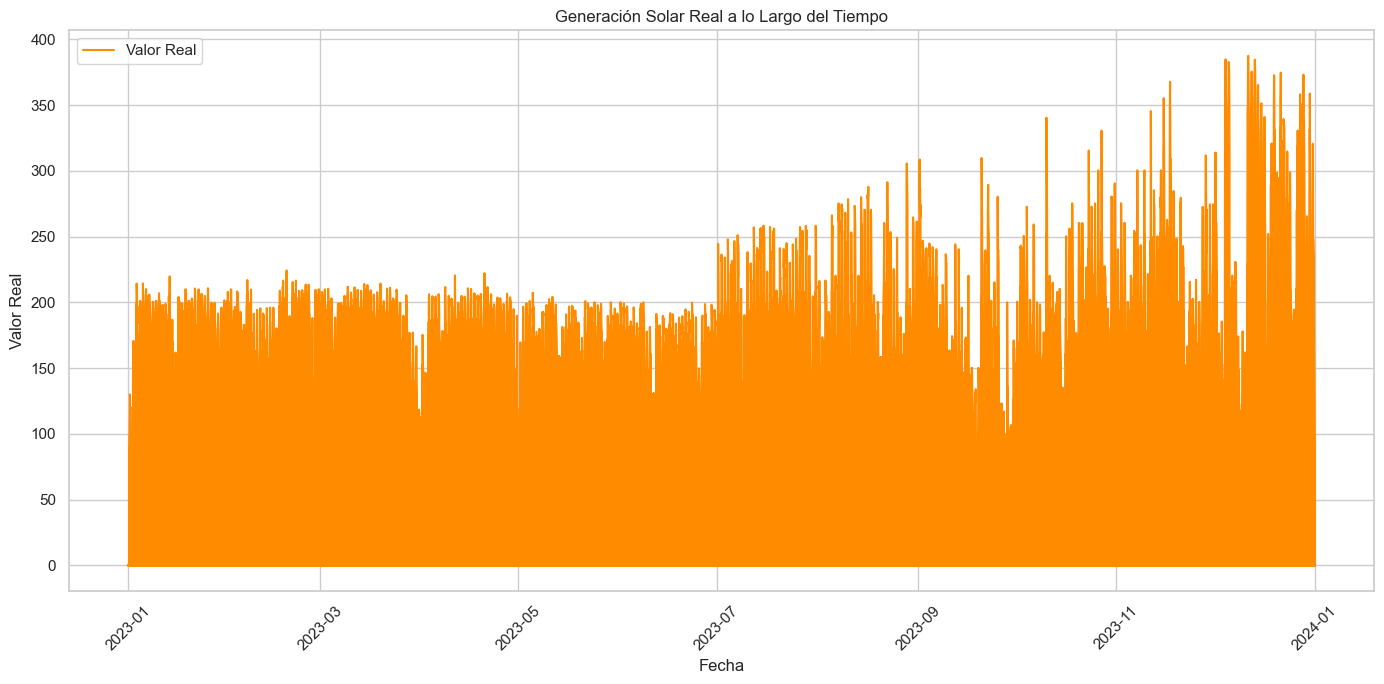

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_18676\3832772217.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Real', data=data, palette="coolwarm")


count    509880.000000
mean         20.529327
std          37.465779
min           0.000000
25%           0.000000
50%           0.200000
75%          28.310000
max         387.430000
Name: Real, dtype: float64

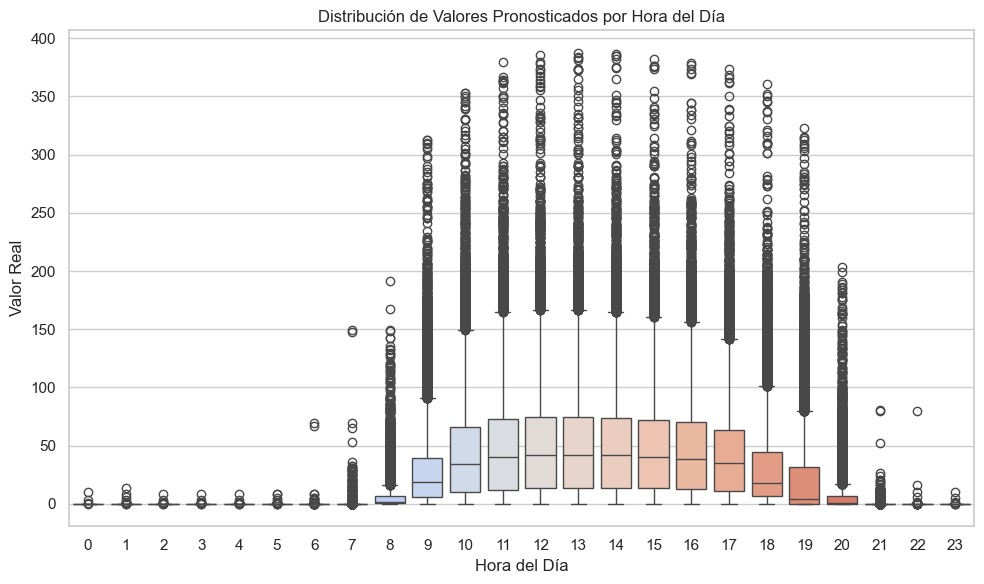

In [ ]:
# Configuración de visualización
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Real'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Real'], label='Valor Real', color='darkorange')
plt.title('Generación Solar Real a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Real', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronosticados por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Real')
plt.tight_layout()

descripcion


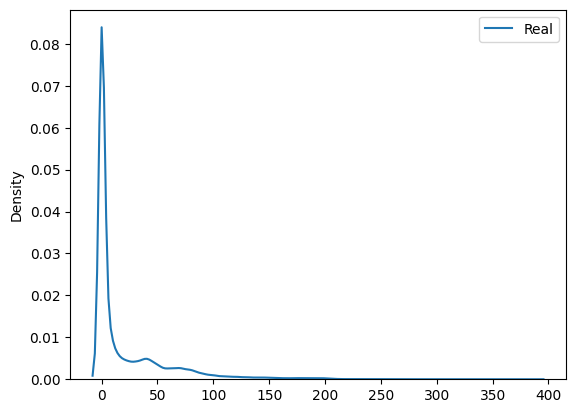

In [ ]:
# Visualización KDE
sn.kdeplot(real)
plt.show()

### Data set Pronostico externo

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Solares"
prefijo_archivo = "P.ExternoSolar"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados

Archivo encontrado: P.ExternoSolar - ENE23.xlsx en 2023/Datos Solares\Datos solar enero 2023
Archivo encontrado: P.ExternoSolar - FEB23.xlsx en 2023/Datos Solares\Datos solar Febrero 2023
Archivo encontrado: P.ExternoSolar - MAY23.xlsx en 2023/Datos Solares\Datos Solar Mayo 2023
Archivo encontrado: P.ExternoSolar - ABR23.xlsx en 2023/Datos Solares\Datos solares abril 2023
Archivo encontrado: P.ExternoSolar - AGO23.xlsx en 2023/Datos Solares\Datos solares agosto 2023
Archivo encontrado: P.ExternoSolar - DIC23.xlsx en 2023/Datos Solares\Datos solares diciembre 2023
Archivo encontrado: P.ExternoSolar - JUL23.xlsx en 2023/Datos Solares\Datos solares julio 2023
Archivo encontrado: P.ExternoSolar - JUN23.xlsx en 2023/Datos Solares\datos solares junio 2023
Archivo encontrado: P.ExternoSolar - MAR23.xlsx en 2023/Datos Solares\Datos Solares marzo 2023
Archivo encontrado: P.ExternoSolar - NOV23.xlsx en 2023/Datos Solares\Datos solares noviembre 2023
Archivo encontrado: P.ExternoSolar - OCT23.xls

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\1574487558.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dataframes, ignore_index=True)


In [ ]:
data

,Nombre,Fecha,Valor
0,PFV USYA,2023-01-01 00:00:00,0.0
1,PFV USYA,2023-01-01 01:00:00,0.0
2,PFV USYA,2023-01-01 02:00:00,0.0
3,PFV USYA,2023-01-01 03:00:00,0.0
4,PFV USYA,2023-01-01 04:00:00,0.0
...,...,...,...
431395,PFV JAMA,2023-09-30 19:00:00,1.8
431396,PFV JAMA,2023-09-30 20:00:00,0.0
431397,PFV JAMA,2023-09-30 21:00:00,0.0
431398,PFV JAMA,2023-09-30 22:00:00,0.0


In [ ]:
data.rename(columns={'Valor':'Externo'}, inplace=True)
externo = data
#data_filtrado = data[data['Externo'] > 0]  # Ajusta este umbral según sea necesario
#data = data_filtrado

In [ ]:
externo

,Nombre,Fecha,Externo
0,PFV USYA,2023-01-01 00:00:00,0.0
1,PFV USYA,2023-01-01 01:00:00,0.0
2,PFV USYA,2023-01-01 02:00:00,0.0
3,PFV USYA,2023-01-01 03:00:00,0.0
4,PFV USYA,2023-01-01 04:00:00,0.0
...,...,...,...
431395,PFV JAMA,2023-09-30 19:00:00,1.8
431396,PFV JAMA,2023-09-30 20:00:00,0.0
431397,PFV JAMA,2023-09-30 21:00:00,0.0
431398,PFV JAMA,2023-09-30 22:00:00,0.0


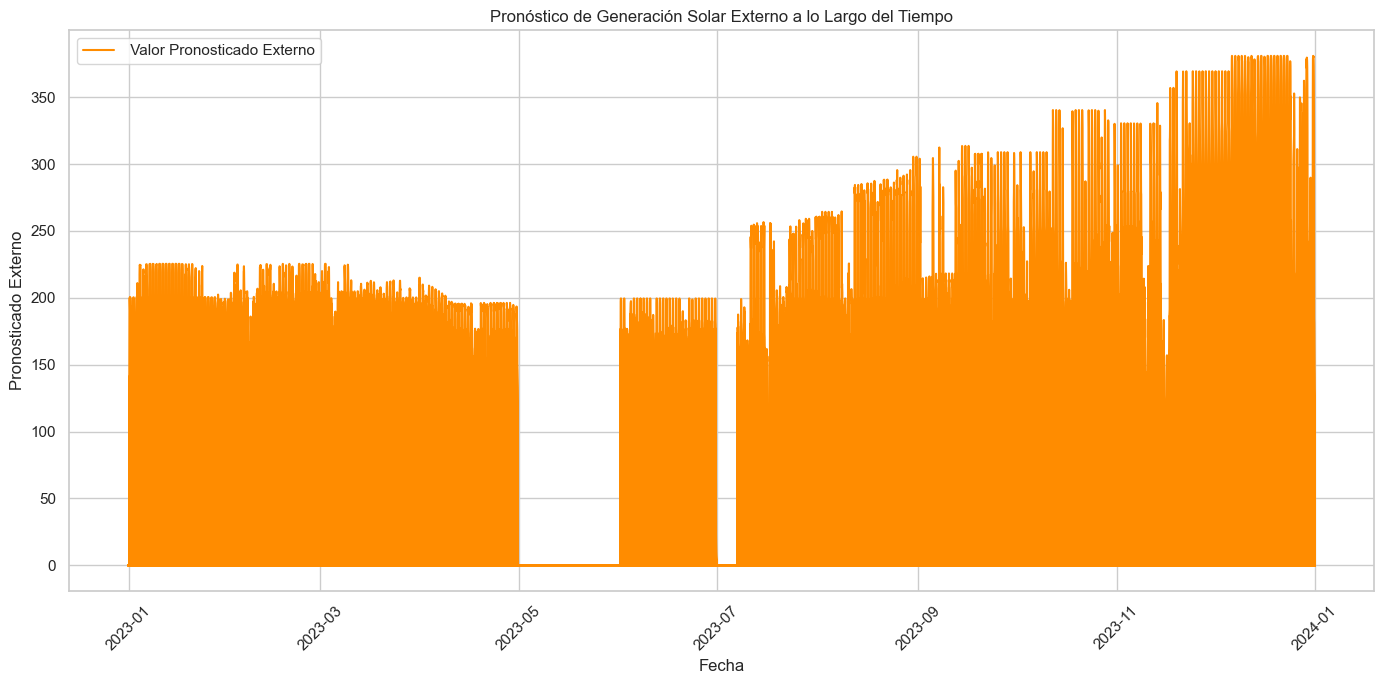

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\2606212191.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Externo', data=data, palette="coolwarm")


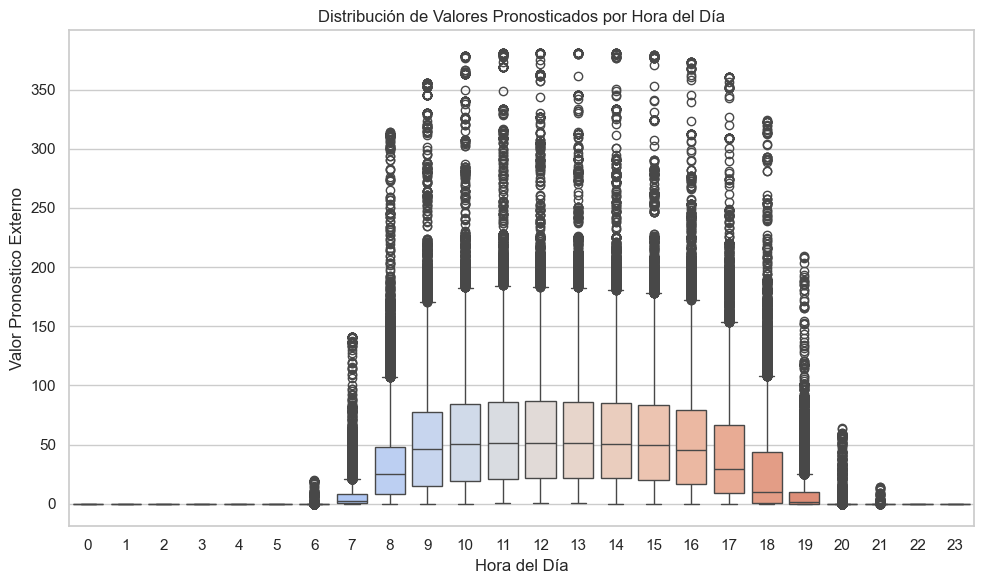

In [ ]:
# Configuración de visualización
#data = df7
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Externo'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Externo'], label=' Valor Pronosticado Externo', color='darkorange')
plt.title('Pronóstico de Generación Solar Externo a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Pronosticado Externo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Externo', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronosticados por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronostico Externo')
plt.tight_layout()

data.drop(columns={'Hora'},axis=1, inplace=True)


### Data set Coordinados

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Solares"
prefijo_archivo = "CoordinadosSolar"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados

Archivo encontrado: CoordinadosSolar - ENE23.xlsx en 2023/Datos Solares\Datos solar enero 2023
Archivo encontrado: CoordinadosSolar - FEB23.xlsx en 2023/Datos Solares\Datos solar Febrero 2023
Archivo encontrado: CoordinadosSolar - MAY23.xlsx en 2023/Datos Solares\Datos Solar Mayo 2023
Archivo encontrado: CoordinadosSolar - ABR23.xlsx en 2023/Datos Solares\Datos solares abril 2023
Archivo encontrado: CoordinadosSolar - AGO23.xlsx en 2023/Datos Solares\Datos solares agosto 2023
Archivo encontrado: CoordinadosSolar - DIC23.xlsx en 2023/Datos Solares\Datos solares diciembre 2023
Archivo encontrado: CoordinadosSolar - JUL23.xlsx en 2023/Datos Solares\Datos solares julio 2023
Archivo encontrado: CoordinadosSolar - JUN23.xlsx en 2023/Datos Solares\datos solares junio 2023
Archivo encontrado: CoordinadosSolar - MAR23.xlsx en 2023/Datos Solares\Datos Solares marzo 2023
Archivo encontrado: CoordinadosSolar - NOV23.xlsx en 2023/Datos Solares\Datos solares noviembre 2023
Archivo encontrado: Coordi

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\1510159168.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dataframes, ignore_index=True)


In [ ]:
data

,Nombre,Valor,Fecha
0,PFV USYA,0.0,2023-01-01 00:00:00
1,PFV USYA,0.0,2023-01-01 01:00:00
2,PFV USYA,0.0,2023-01-01 02:00:00
3,PFV USYA,0.0,2023-01-01 03:00:00
4,PFV USYA,0.0,2023-01-01 04:00:00
...,...,...,...
416755,PFV JAMA,3.0,2023-09-28 19:00:00
416756,PFV JAMA,0.0,2023-09-28 20:00:00
416757,PFV JAMA,0.0,2023-09-28 21:00:00
416758,PFV JAMA,0.0,2023-09-28 22:00:00


In [ ]:
# Asegurarte de que todos los valores en la columna 'Valor' sean strings antes de aplicar operaciones de strings
data['Valor'] = data['Valor'].astype(str)

# Reemplazar comas por puntos en la columna 'Valor'
data['Valor'] = data['Valor'].str.replace(',', '.')

# Convertir la columna 'Valor' a flotante, manejando los errores con 'coerce'
data['Valor'] = pd.to_numeric(data['Valor'], errors='coerce')

# Mostrar el resultado
print(data)



          Nombre  Valor               Fecha
0       PFV USYA    0.0 2023-01-01 00:00:00
1       PFV USYA    0.0 2023-01-01 01:00:00
2       PFV USYA    0.0 2023-01-01 02:00:00
3       PFV USYA    0.0 2023-01-01 03:00:00
4       PFV USYA    0.0 2023-01-01 04:00:00
...          ...    ...                 ...
416755  PFV JAMA    3.0 2023-09-28 19:00:00
416756  PFV JAMA    0.0 2023-09-28 20:00:00
416757  PFV JAMA    0.0 2023-09-28 21:00:00
416758  PFV JAMA    0.0 2023-09-28 22:00:00
416759  PFV JAMA    0.0 2023-09-28 23:00:00

[416760 rows x 3 columns]


In [ ]:
data.rename(columns={'Valor': 'Coordinado'}, inplace=True)
#data_filtrado = data[data['Coordinado'] > 0]  # Ajusta este umbral según sea necesario
#data = data_filtrado
coordinado = data

In [ ]:
coordinado

,Nombre,Coordinado,Fecha
0,PFV USYA,0.0,2023-01-01 00:00:00
1,PFV USYA,0.0,2023-01-01 01:00:00
2,PFV USYA,0.0,2023-01-01 02:00:00
3,PFV USYA,0.0,2023-01-01 03:00:00
4,PFV USYA,0.0,2023-01-01 04:00:00
...,...,...,...
416755,PFV JAMA,3.0,2023-09-28 19:00:00
416756,PFV JAMA,0.0,2023-09-28 20:00:00
416757,PFV JAMA,0.0,2023-09-28 21:00:00
416758,PFV JAMA,0.0,2023-09-28 22:00:00


In [ ]:
data.describe(include='all').round(1)

,Nombre,Coordinado,Fecha
count,416760,416760.0,416760
unique,62,NaN,NaN
top,PFV ATACAMA SOLAR II,NaN,NaN
freq,8016,NaN,NaN
mean,NaN,28.5,2023-07-12 09:41:07.135041536
min,NaN,0.0,2023-01-01 00:00:00
25%,NaN,0.0,2023-04-02 19:00:00
50%,NaN,0.8,2023-07-24 16:00:00
75%,NaN,44.8,2023-10-12 04:00:00
max,NaN,350.0,2023-12-31 23:00:00


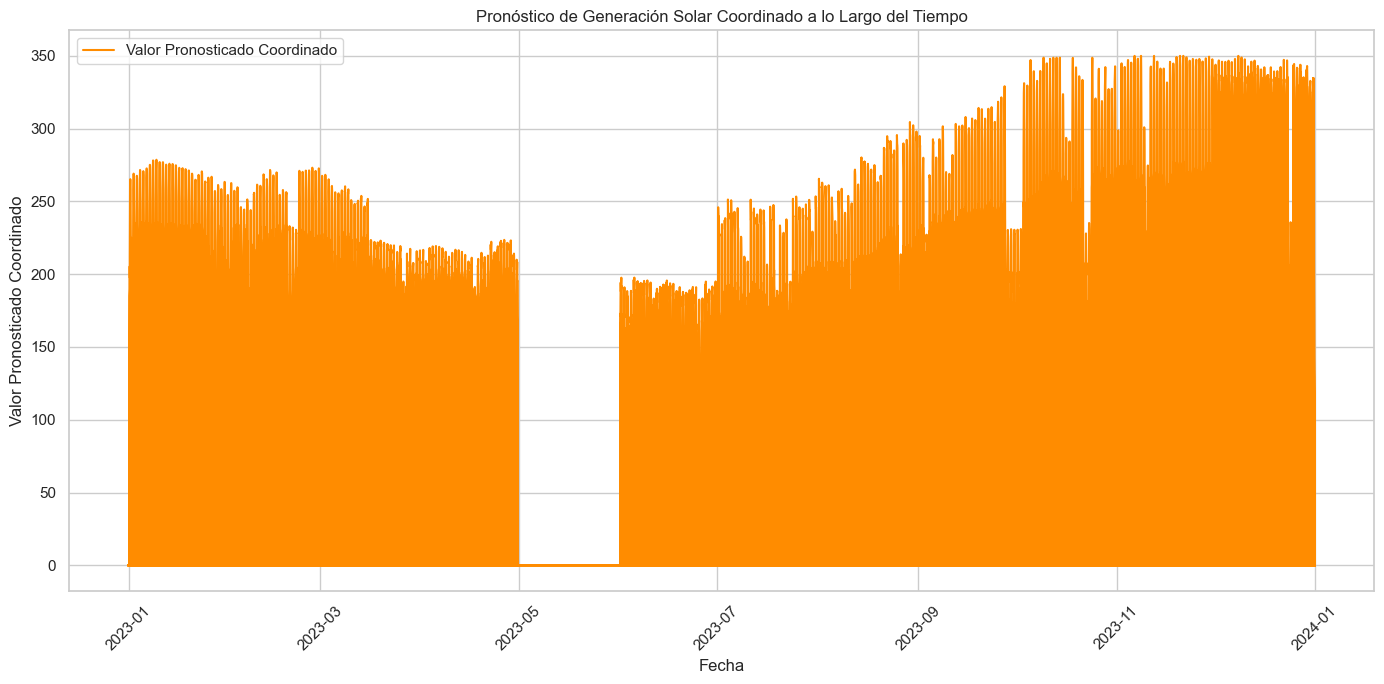

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\3176678589.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Coordinado', data=data, palette="coolwarm")


count    416760.000000
mean         28.490553
std          48.090161
min           0.000000
25%           0.000000
50%           0.800000
75%          44.800000
max         350.000000
Name: Coordinado, dtype: float64

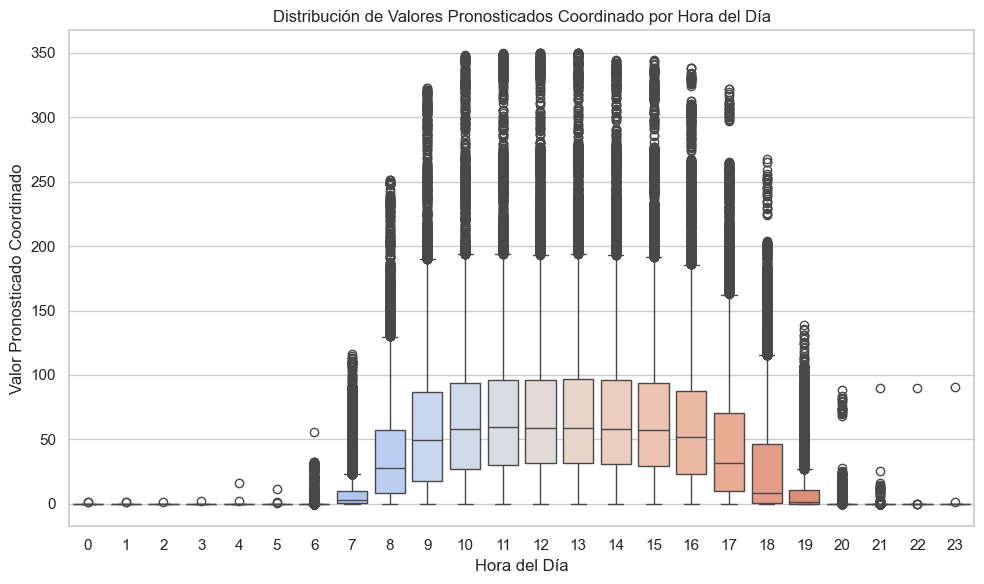

In [ ]:

# Configuración de visualización
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Coordinado'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Coordinado'], label='Valor Pronosticado Coordinado', color='darkorange')
plt.title('Pronóstico de Generación Solar Coordinado a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Pronosticado Coordinado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Coordinado', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronosticados Coordinado por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronosticado Coordinado')
plt.tight_layout()

descripcion


In [ ]:
data.describe(include='all').round(1)

,Nombre,Coordinado,Fecha,Hora
count,416760,416760.0,416760,416760.0
unique,62,NaN,NaN,NaN
top,PFV ATACAMA SOLAR II,NaN,NaN,NaN
freq,8016,NaN,NaN,NaN
mean,NaN,28.5,2023-07-12 09:41:07.135041536,11.5
min,NaN,0.0,2023-01-01 00:00:00,0.0
25%,NaN,0.0,2023-04-02 19:00:00,5.8
50%,NaN,0.8,2023-07-24 16:00:00,11.5
75%,NaN,44.8,2023-10-12 04:00:00,17.2
max,NaN,350.0,2023-12-31 23:00:00,23.0


In [ ]:
data[data['Hora']== 23]

,Nombre,Coordinado,Fecha,Hora
23,PFV USYA,0.0,2023-01-01 23:00:00,23
47,PFV ATACAMA SOLAR II,0.0,2023-01-01 23:00:00,23
71,PFV LA HUELLA,0.0,2023-01-01 23:00:00,23
95,PFV MALGARIDA,0.0,2023-01-01 23:00:00,23
119,PFV LA CRUZ SOLAR,0.0,2023-01-01 23:00:00,23
...,...,...,...,...
416663,PFV JAMA,0.0,2023-09-24 23:00:00,23
416687,PFV JAMA,0.0,2023-09-25 23:00:00,23
416711,PFV JAMA,0.0,2023-09-26 23:00:00,23
416735,PFV JAMA,0.0,2023-09-27 23:00:00,23


### Data set Pronostico Sistema Experto


In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Solares"
prefijo_archivo = "SistemaExpertoSolar"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados

Archivo encontrado: SistemaExpertoSolar - ENE23.xlsx en 2023/Datos Solares\Datos solar enero 2023
Archivo encontrado: SistemaExpertoSolar - FEB23.xlsx en 2023/Datos Solares\Datos solar Febrero 2023
Archivo encontrado: SistemaExpertoSolar - MAY23.xlsx en 2023/Datos Solares\Datos Solar Mayo 2023
Archivo encontrado: SistemaExpertoSolar - ABR23.xlsx en 2023/Datos Solares\Datos solares abril 2023
Archivo encontrado: SistemaExpertoSolar - AGO23.xlsx en 2023/Datos Solares\Datos solares agosto 2023
Archivo encontrado: SistemaExpertoSolar - DIC23.xlsx en 2023/Datos Solares\Datos solares diciembre 2023
Archivo encontrado: SistemaExpertoSolar - JUL23.xlsx en 2023/Datos Solares\Datos solares julio 2023
Archivo encontrado: SistemaExpertoSolar - JUN23.xlsx en 2023/Datos Solares\datos solares junio 2023
Archivo encontrado: SistemaExpertoSolar - MAR23.xlsx en 2023/Datos Solares\Datos Solares marzo 2023
Archivo encontrado: SistemaExpertoSolar - NOV23.xlsx en 2023/Datos Solares\Datos solares noviembre 2

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\642961216.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dataframes, ignore_index=True)


In [ ]:
data

,Nombre,Fecha,Valor
0,PFV USYA,2023-01-01 00:00:00,0.000
1,PFV USYA,2023-01-01 01:00:00,0.000
2,PFV USYA,2023-01-01 02:00:00,0.000
3,PFV USYA,2023-01-01 03:00:00,0.000
4,PFV USYA,2023-01-01 04:00:00,0.000
...,...,...,...
403933,PFV JAMA,2023-09-30 19:00:00,1.837
403934,PFV JAMA,2023-09-30 20:00:00,0.000
403935,PFV JAMA,2023-09-30 21:00:00,0.000
403936,PFV JAMA,2023-09-30 22:00:00,0.000


In [ ]:
data.rename(columns={'Valor':'SExperto'}, inplace=True)
SExperto= data


In [ ]:
SExperto

,Nombre,Fecha,SExperto
0,PFV USYA,2023-01-01 00:00:00,0.000
1,PFV USYA,2023-01-01 01:00:00,0.000
2,PFV USYA,2023-01-01 02:00:00,0.000
3,PFV USYA,2023-01-01 03:00:00,0.000
4,PFV USYA,2023-01-01 04:00:00,0.000
...,...,...,...
403933,PFV JAMA,2023-09-30 19:00:00,1.837
403934,PFV JAMA,2023-09-30 20:00:00,0.000
403935,PFV JAMA,2023-09-30 21:00:00,0.000
403936,PFV JAMA,2023-09-30 22:00:00,0.000


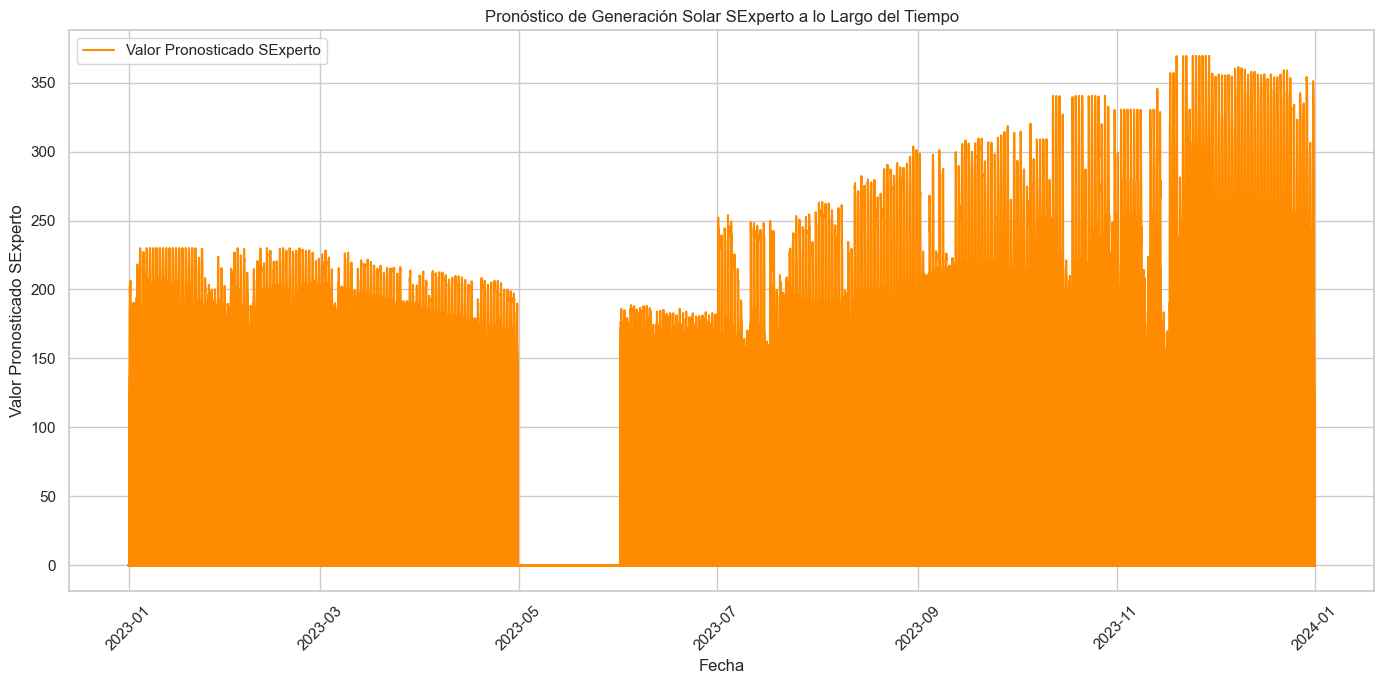

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\1301683623.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='SExperto', data=data, palette="coolwarm")


count    403938.000000
mean         27.949850
std          45.302018
min           0.000000
25%           0.000000
50%           1.141000
75%          44.208000
max         369.400000
Name: SExperto, dtype: float64

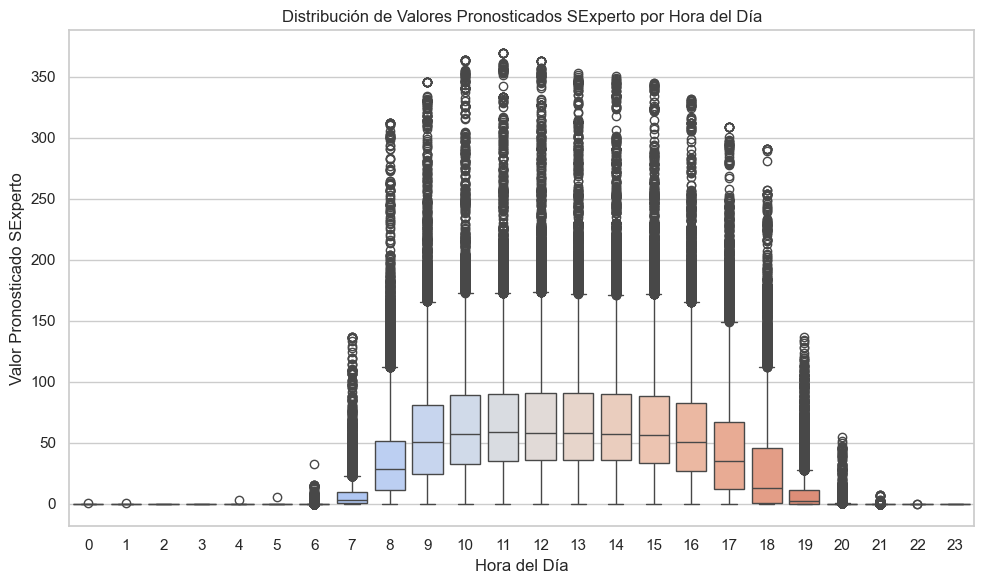

In [ ]:
# Configuración de visualización
#data = df7
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['SExperto'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['SExperto'], label='Valor Pronosticado SExperto', color='darkorange')
plt.title('Pronóstico de Generación Solar SExperto a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Pronosticado SExperto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='SExperto', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronosticados SExperto por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronosticado SExperto')
plt.tight_layout()

descripcion


### Data Set Vertimiento

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Solares"
prefijo_archivo = "Vertimiento"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados


Archivo encontrado: Vertimiento - ENE23.xlsx en 2023/Datos Solares\Datos solar enero 2023
Archivo encontrado: Vertimiento - FEB23.xlsx en 2023/Datos Solares\Datos solar Febrero 2023
Archivo encontrado: Vertimiento - MAY23.xlsx en 2023/Datos Solares\Datos Solar Mayo 2023
Archivo encontrado: Vertimiento - ABR23.xlsx en 2023/Datos Solares\Datos solares abril 2023
Archivo encontrado: Vertimiento - AGO23.xlsx en 2023/Datos Solares\Datos solares agosto 2023
Archivo encontrado: Vertimiento - DIC23.xlsx en 2023/Datos Solares\Datos solares diciembre 2023
Archivo encontrado: Vertimiento - JUL23.xlsx en 2023/Datos Solares\Datos solares julio 2023
Archivo encontrado: Vertimiento - JUN23.xlsx en 2023/Datos Solares\datos solares junio 2023
Archivo encontrado: Vertimiento - MAR23.xlsx en 2023/Datos Solares\Datos Solares marzo 2023
Archivo encontrado: Vertimiento - NOV23.xlsx en 2023/Datos Solares\Datos solares noviembre 2023
Archivo encontrado: Vertimiento - OCT23.xlsx en 2023/Datos Solares\Datos sol

Leyendo archivo: 2023/Datos Solares\Datos solar Febrero 2023\Vertimiento - FEB23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos Solar Mayo 2023\Vertimiento - MAY23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos solares abril 2023\Vertimiento - ABR23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos solares agosto 2023\Vertimiento - AGO23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos solares diciembre 2023\Vertimiento - DIC23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos solares julio 2023\Vertimiento - JUL23.xlsx
Leyendo archivo: 2023/Datos Solares\datos solares junio 2023\Vertimiento - JUN23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos Solares marzo 2023\Vertimiento - MAR23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos solares noviembre 2023\Vertimiento - NOV23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos solares octubre 2023\Vertimiento - OCT23.xlsx
Leyendo archivo: 2023/Datos Solares\Datos solares septiembre 2023\Vertimiento - SEP23.xlsx


In [ ]:
data.rename(columns={'Valor':'Vertimiento'}, inplace=True)
Vertimiento = data

Vertimiento

,Fecha,Nombre,Vertimiento
0,2023-01-01 00:00:00,PFV ALMEYDA,0.0
1,2023-01-01 01:00:00,PFV ALMEYDA,0.0
2,2023-01-01 02:00:00,PFV ALMEYDA,0.0
3,2023-01-01 03:00:00,PFV ALMEYDA,0.0
4,2023-01-01 04:00:00,PFV ALMEYDA,0.0
...,...,...,...
286315,2023-09-01 00:00:00,PFV SOL DE LOS ANDES,0.0
286316,2023-09-01 00:00:00,PFV TAMAYA SOLAR,0.0
286317,2023-09-01 00:00:00,PFV URIBE SOLAR,0.0
286318,2023-09-01 00:00:00,PFV USYA,0.0


In [ ]:
Vertimiento

,Fecha,Nombre,Vertimiento
0,2023-01-01 00:00:00,PFV ALMEYDA,0.0
1,2023-01-01 01:00:00,PFV ALMEYDA,0.0
2,2023-01-01 02:00:00,PFV ALMEYDA,0.0
3,2023-01-01 03:00:00,PFV ALMEYDA,0.0
4,2023-01-01 04:00:00,PFV ALMEYDA,0.0
...,...,...,...
286315,2023-09-01 00:00:00,PFV SOL DE LOS ANDES,0.0
286316,2023-09-01 00:00:00,PFV TAMAYA SOLAR,0.0
286317,2023-09-01 00:00:00,PFV URIBE SOLAR,0.0
286318,2023-09-01 00:00:00,PFV USYA,0.0


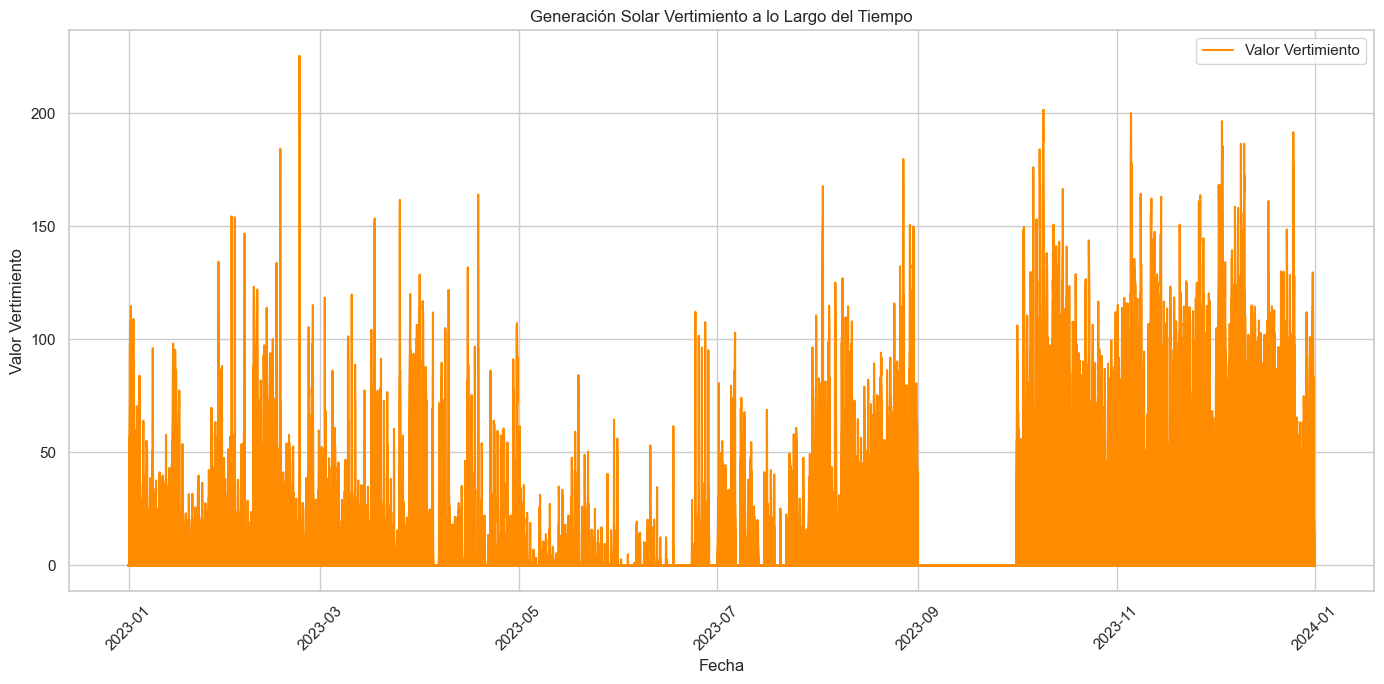

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\43723730.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Vertimiento', data=data, palette="coolwarm")


count    286320.000000
mean          3.714101
std          12.681707
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         225.500000
Name: Vertimiento, dtype: float64

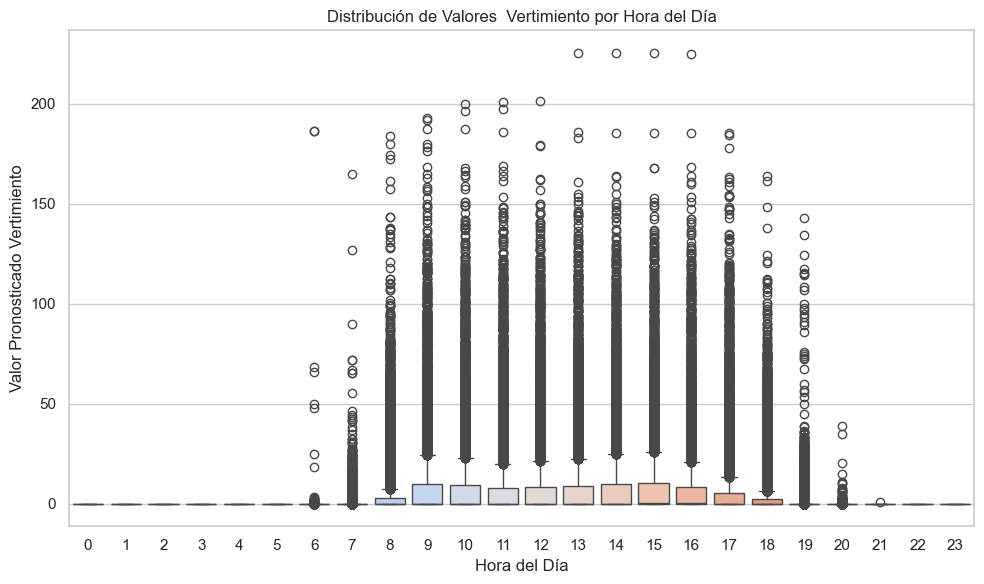

In [ ]:
# Configuración de visualización
#data = df7
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Vertimiento'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Vertimiento'], label='Valor Vertimiento', color='darkorange')
plt.title('Generación Solar Vertimiento a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Vertimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Vertimiento', data=data, palette="coolwarm")
plt.title('Distribución de Valores  Vertimiento por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronosticado Vertimiento')
plt.tight_layout()

descripcion


### Union dataframes

In [ ]:

real
externo
coordinado
SExperto
Vertimiento

,Fecha,Nombre,Vertimiento,Hora
0,2023-01-01 00:00:00,PFV ALMEYDA,0.0,0
1,2023-01-01 01:00:00,PFV ALMEYDA,0.0,1
2,2023-01-01 02:00:00,PFV ALMEYDA,0.0,2
3,2023-01-01 03:00:00,PFV ALMEYDA,0.0,3
4,2023-01-01 04:00:00,PFV ALMEYDA,0.0,4
...,...,...,...,...
286315,2023-09-01 00:00:00,PFV SOL DE LOS ANDES,0.0,0
286316,2023-09-01 00:00:00,PFV TAMAYA SOLAR,0.0,0
286317,2023-09-01 00:00:00,PFV URIBE SOLAR,0.0,0
286318,2023-09-01 00:00:00,PFV USYA,0.0,0


In [ ]:
df_cruzado.drop(['Hora_x','Hora_y'],axis=1, inplace=True)

NameError: name 'df_cruzado' is not defined

In [ ]:
df_cruzado = pd.merge(real, externo,  on=['Nombre', 'Fecha'], how='outer')
df_cruzado = pd.merge(df_cruzado, coordinado,  on=['Nombre', 'Fecha'], how='outer')
df_cruzado = pd.merge(df_cruzado, SExperto,  on=['Nombre', 'Fecha'], how='outer')
df_cruzado = pd.merge(df_cruzado, Vertimiento,  on=['Nombre', 'Fecha'], how='outer')
df_cruzado.drop(['Hora_x','Hora_y'],axis=1, inplace=True)
df_cruzado

,Real,Nombre,Fecha,Externo,Coordinado,SExperto,Vertimiento,Hora
0,NaN,PFV ALMEYDA,2023-01-01 00:00:00,0.0,0.0,0.000,0.0,0.0
1,0.00,PFV ALMEYDA,2023-01-01 01:00:00,0.0,0.0,0.000,0.0,1.0
2,0.00,PFV ALMEYDA,2023-01-01 02:00:00,0.0,0.0,0.000,0.0,2.0
3,0.00,PFV ALMEYDA,2023-01-01 03:00:00,0.0,0.0,0.000,0.0,3.0
4,0.00,PFV ALMEYDA,2023-01-01 04:00:00,0.0,0.0,0.000,0.0,4.0
...,...,...,...,...,...,...,...,...
509937,37.05,PFV VALLE ESCONDIDO,2023-12-31 20:00:00,4.2,2.0,4.844,0.0,20.0
509938,3.18,PFV VALLE ESCONDIDO,2023-12-31 21:00:00,0.0,0.0,0.000,0.0,21.0
509939,0.00,PFV VALLE ESCONDIDO,2023-12-31 22:00:00,0.0,0.0,0.000,0.0,22.0
509940,0.00,PFV VALLE ESCONDIDO,2023-12-31 23:00:00,0.0,0.0,0.000,0.0,23.0


In [ ]:
df = df_cruzado
Pronosticos = df_cruzado
#df['generacion_potencial'] = df['Real'] + df['Vertimiento'].fillna(0)
df['Tecnologia'] = 'Solar'
df_solar = df
df_solar


,Real,Nombre,Fecha,Externo,Coordinado,SExperto,Vertimiento,Hora,Tecnologia
0,NaN,PFV ALMEYDA,2023-01-01 00:00:00,0.0,0.0,0.000,0.0,0.0,Solar
1,0.00,PFV ALMEYDA,2023-01-01 01:00:00,0.0,0.0,0.000,0.0,1.0,Solar
2,0.00,PFV ALMEYDA,2023-01-01 02:00:00,0.0,0.0,0.000,0.0,2.0,Solar
3,0.00,PFV ALMEYDA,2023-01-01 03:00:00,0.0,0.0,0.000,0.0,3.0,Solar
4,0.00,PFV ALMEYDA,2023-01-01 04:00:00,0.0,0.0,0.000,0.0,4.0,Solar
...,...,...,...,...,...,...,...,...,...
509937,37.05,PFV VALLE ESCONDIDO,2023-12-31 20:00:00,4.2,2.0,4.844,0.0,20.0,Solar
509938,3.18,PFV VALLE ESCONDIDO,2023-12-31 21:00:00,0.0,0.0,0.000,0.0,21.0,Solar
509939,0.00,PFV VALLE ESCONDIDO,2023-12-31 22:00:00,0.0,0.0,0.000,0.0,22.0,Solar
509940,0.00,PFV VALLE ESCONDIDO,2023-12-31 23:00:00,0.0,0.0,0.000,0.0,23.0,Solar


In [ ]:
ruta_archivo_excel = 'df_solar.xlsx'

# Usar el método to_excel para exportar el DataFrame a Excel, especificando el engine como 'openpyxl'
df.to_excel(ruta_archivo_excel, engine='openpyxl', index=False)

print(f'El DataFrame ha sido exportado a {ruta_archivo_excel}')

El DataFrame ha sido exportado a df_solar.xlsx


## Eólico

### Data Set Real Eólica

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Eolicos"
prefijo_archivo = "RealEolico"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados


Archivo encontrado: RealEolico - ABR23.xlsx en 2023/Datos Eolicos\Eolico-Abril-2023\Datos Eólicos Abril 2023
Archivo encontrado: RealEolico - AGO23.xlsx en 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023
Archivo encontrado: RealEolico - DIC23.xlsx en 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023
Archivo encontrado: RealEolico - ENE23.xlsx en 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023
Archivo encontrado: RealEolico - FEB23.xlsx en 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023
Archivo encontrado: RealEolico - JUL23.xlsx en 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023
Archivo encontrado: RealEolico - JUN23.xlsx en 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023
Archivo encontrado: RealEolico - MAR23.xlsx en 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023
Archivo encontrado: RealEolico - MAY23.xlsx en 2023/Datos Eolicos\Eolico-Mayo-2023\Datos Eólicos Mayo 2023
Archivo

In [ ]:

data.rename(columns={'Valor': 'Real'}, inplace=True)
real = data

real

,Real,Nombre,Fecha,Hora
0,4.30,PE MONTE REDONDO,2023-04-01,1
1,0.40,PE MONTE REDONDO,2023-04-01,2
2,0.10,PE MONTE REDONDO,2023-04-01,3
3,0.30,PE MONTE REDONDO,2023-04-01,4
4,0.00,PE MONTE REDONDO,2023-04-01,5
...,...,...,...,...
383323,7.46,PE LA FLOR,2023-09-30,20
383324,1.98,PE LA FLOR,2023-09-30,21
383325,3.36,PE LA FLOR,2023-09-30,22
383326,9.18,PE LA FLOR,2023-09-30,23


In [ ]:
# Primero, convertimos la columna 'fecha' a datetime y 'hora' a string para manejar el caso de '24'
data['fecha'] = pd.to_datetime(data['Fecha'])
data['hora'] = data['Hora'].astype(str)

# Manejar el caso especial de la hora '24'
data.loc[data['hora'] == '24', 'fecha'] += pd.Timedelta(days=1)
data.loc[data['hora'] == '24', 'hora'] = '00'

# Ahora, combinar las columnas 'fecha' y 'hora' en una nueva columna 'fecha_hora'
data['fecha_hora'] = pd.to_datetime(data['fecha'].astype(str) + ' ' + data['hora'].apply(lambda x: x.zfill(2) + ':00:00'))

data.drop(['Fecha','Hora','fecha','hora'], axis=1, inplace=True)
data.rename(columns={'fecha_hora': 'Fecha'}, inplace=True)


In [ ]:
#real = data
real

,Real,Nombre,Fecha
0,4.30,PE MONTE REDONDO,2023-04-01 01:00:00
1,0.40,PE MONTE REDONDO,2023-04-01 02:00:00
2,0.10,PE MONTE REDONDO,2023-04-01 03:00:00
3,0.30,PE MONTE REDONDO,2023-04-01 04:00:00
4,0.00,PE MONTE REDONDO,2023-04-01 05:00:00
...,...,...,...
383323,7.46,PE LA FLOR,2023-09-30 20:00:00
383324,1.98,PE LA FLOR,2023-09-30 21:00:00
383325,3.36,PE LA FLOR,2023-09-30 22:00:00
383326,9.18,PE LA FLOR,2023-09-30 23:00:00


In [ ]:
real = data
real.describe(include='all').round(1)

,Real,Nombre,Fecha
count,383328.0,383328,383328
unique,NaN,46,NaN
top,NaN,PE MONTE REDONDO,NaN
freq,NaN,8760,NaN
mean,22.8,NaN,2023-07-06 09:02:21.998497536
min,0.0,NaN,2023-01-01 01:00:00
25%,0.4,NaN,2023-04-06 17:00:00
50%,8.3,NaN,2023-07-08 09:00:00
75%,31.1,NaN,2023-10-06 05:00:00
max,206.7,NaN,2024-01-01 00:00:00


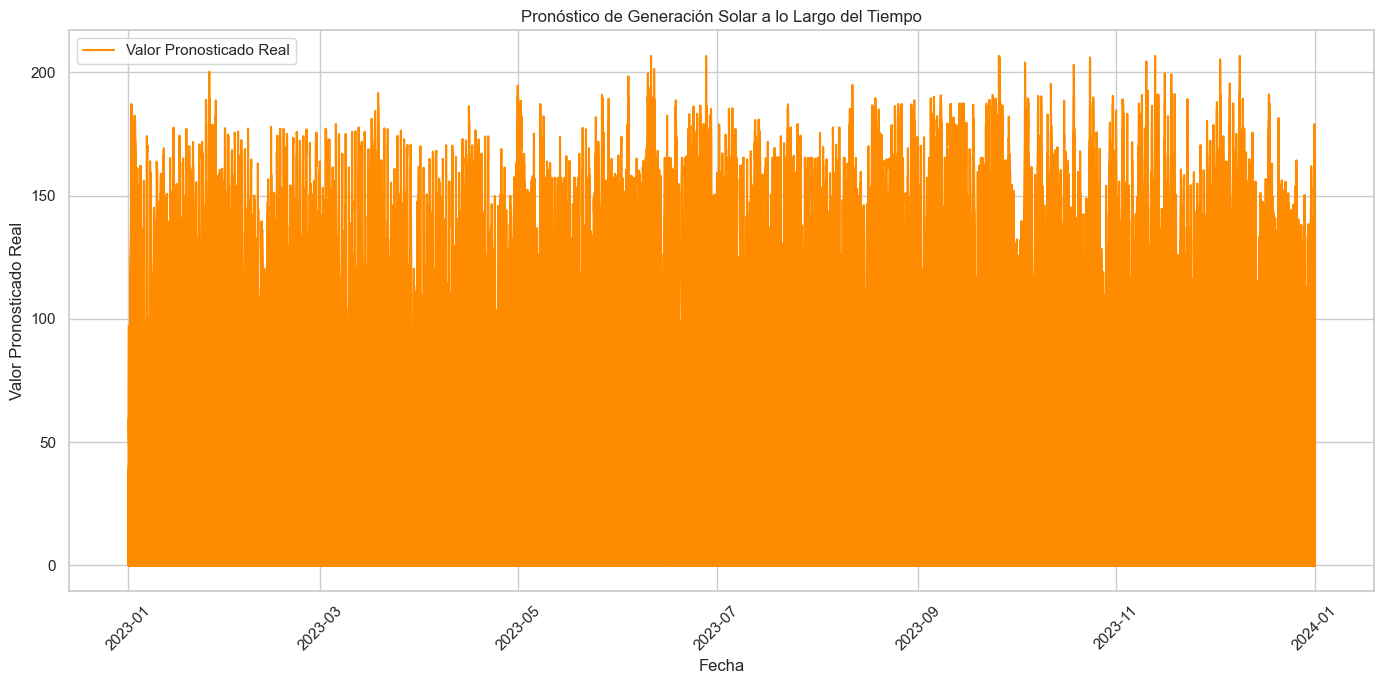

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_18676\2749098368.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Real', data=data, palette="coolwarm")


count    383328.000000
mean         22.753299
std          32.832971
min           0.000000
25%           0.406226
50%           8.320000
75%          31.080000
max         206.720000
Name: Real, dtype: float64

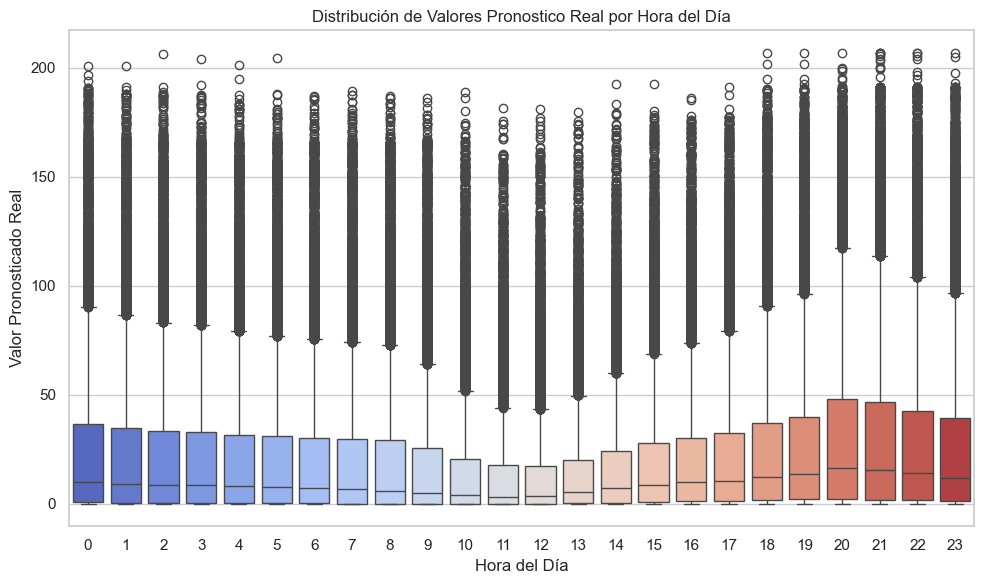

In [ ]:
# Configuración de visualización
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Real'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Real'], label='Valor Pronosticado Real', color='darkorange')
plt.title('Pronóstico de Generación Solar a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Pronosticado Real')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Real', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronostico Real por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronosticado Real')
plt.tight_layout()

descripcion

### Data set Pronostico externo

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Eolicos"
prefijo_archivo = "P.ExternoEolico"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados


Archivo encontrado: P.ExternoEolico - ABR23.xlsx en 2023/Datos Eolicos\Eolico-Abril-2023\Datos Eólicos Abril 2023
Archivo encontrado: P.ExternoEolico - AGO23.xlsx en 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023
Archivo encontrado: P.ExternoEolico - DIC23.xlsx en 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023
Archivo encontrado: P.ExternoEolico- ENE23.xlsx en 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023
Archivo encontrado: P.ExternoEolico - FEB23.xlsx en 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023
Archivo encontrado: P.ExternoEolico- JUL23.xlsx en 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023
Archivo encontrado: P.ExternoEolico - JUN23.xlsx en 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023
Archivo encontrado: P.ExternoEolico - MAR23.xlsx en 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023
Archivo encontrado: P.ExternoEolico - MAY23.xlsx en 2023/Datos Eolicos\Eolic

In [ ]:
externo = data
externo.rename(columns={'Valor':'Externo'}, inplace=True)
externo.sort_values(by=['Nombre', 'Fecha'])

#qgrid_widget = qg.show_grid(externo, show_toolbar=True)
#qgrid_widget

,Nombre,Fecha,Externo
96576,PE ALENA,2023-01-01 00:00:00,14.7
96577,PE ALENA,2023-01-01 01:00:00,10.4
96578,PE ALENA,2023-01-01 02:00:00,4.7
96579,PE ALENA,2023-01-01 03:00:00,2.5
96580,PE ALENA,2023-01-01 04:00:00,2.0
...,...,...,...
96283,PE VALLE DE LOS VIENTOS,2023-12-31 19:00:00,65.5
96284,PE VALLE DE LOS VIENTOS,2023-12-31 20:00:00,64.7
96285,PE VALLE DE LOS VIENTOS,2023-12-31 21:00:00,47.2
96286,PE VALLE DE LOS VIENTOS,2023-12-31 22:00:00,27.4


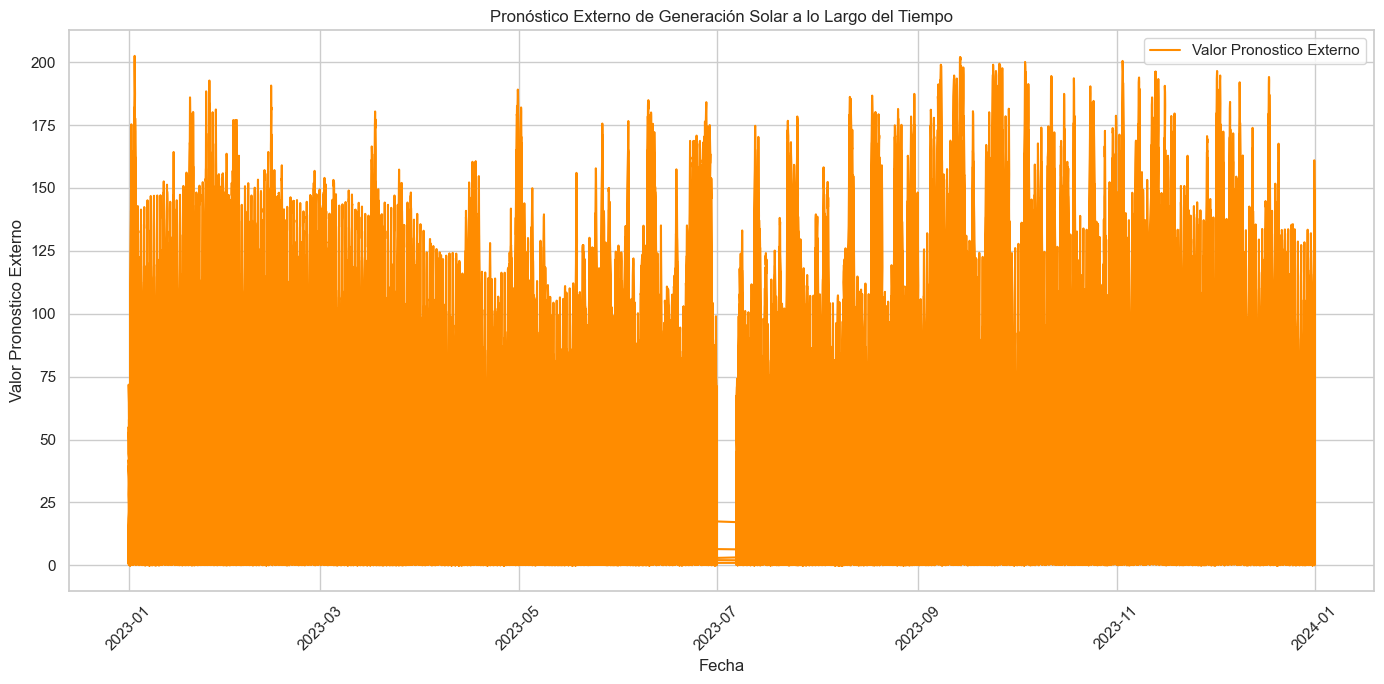

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\3877047541.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Externo', data=data, palette="coolwarm")


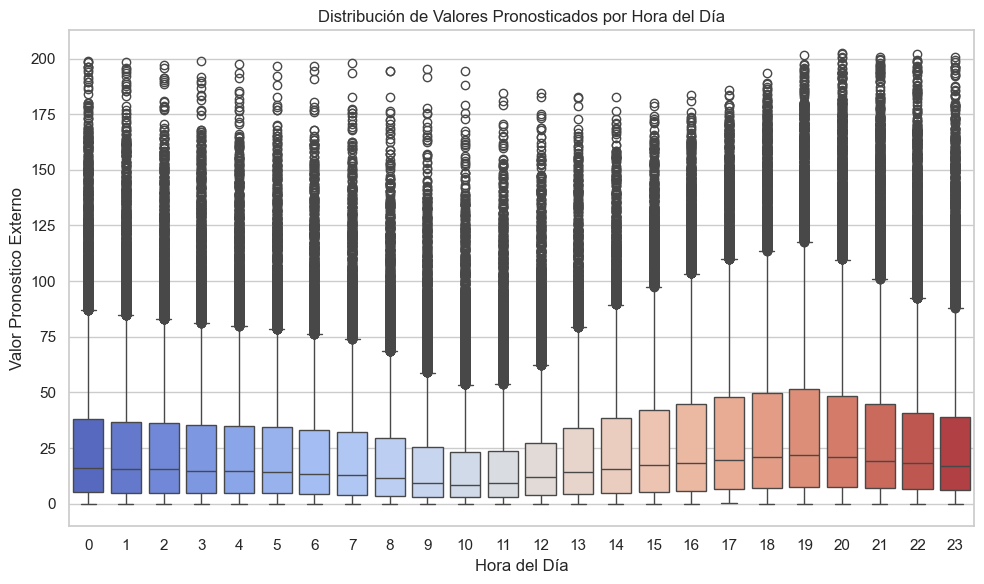

In [ ]:
# Configuración de visualización
#data = df7
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Externo'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Externo'], label='Valor Pronostico Externo', color='darkorange')
plt.title('Pronóstico Externo de Generación Solar a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Pronostico Externo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Externo', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronosticados por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronostico Externo')
plt.tight_layout()

descripcion
data.drop(columns={'Hora'},axis=1, inplace=True)

### Data set Coordinados

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Eolicos"
prefijo_archivo = "CoordinadosEolico"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados

Archivo encontrado: CoordinadosEolico - ABR23.xlsx en 2023/Datos Eolicos\Eolico-Abril-2023\Datos Eólicos Abril 2023
Archivo encontrado: CoordinadosEolico - AGO23.xlsx en 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023
Archivo encontrado: CoordinadosEolico - DIC23.xlsx en 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023
Archivo encontrado: CoordinadosEolico - ENE23.xlsx en 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023
Archivo encontrado: CoordinadosEolico - FEB23.xlsx en 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023
Archivo encontrado: CoordinadosEolico - JUL23.xlsx en 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023
Archivo encontrado: CoordinadosEolico - JUN23.xlsx en 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023
Archivo encontrado: CoordinadosEolico - MAR23.xlsx en 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023
Archivo encontrado: CoordinadosEolico - MAY23.xlsx en 2023

Leyendo archivo: 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023\CoordinadosEolico - AGO23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023\CoordinadosEolico - DIC23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023\CoordinadosEolico - ENE23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023\CoordinadosEolico - FEB23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023\CoordinadosEolico - JUL23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023\CoordinadosEolico - JUN23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023\CoordinadosEolico - MAR23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Mayo-2023\Datos Eólicos Mayo 2023\CoordinadosEolico - MAY23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Noviembre-2023\Datos eólicos noviembre 2023\CoordinadosEolico - N

In [ ]:
data.rename(columns={'Valor':'Coordinado'}, inplace=True)
coordinado = data 


In [ ]:
data.dtypes

Nombre                object
Coordinado           float64
Fecha         datetime64[ns]
dtype: object

In [ ]:

coordinado

,Nombre,Coordinado,Fecha
0,PE CANELA,2.85,2023-04-01 00:00:00
1,PE CANELA,2.26,2023-04-01 01:00:00
2,PE CANELA,1.73,2023-04-01 02:00:00
3,PE CANELA,1.29,2023-04-01 03:00:00
4,PE CANELA,0.85,2023-04-01 04:00:00
...,...,...,...
353179,PE LEBU,0.12,2023-09-30 19:00:00
353180,PE LEBU,0.13,2023-09-30 20:00:00
353181,PE LEBU,0.18,2023-09-30 21:00:00
353182,PE LEBU,0.19,2023-09-30 22:00:00


In [ ]:
data.describe(include='all').round(1)

,Nombre,Coordinado,Fecha
count,353184,353184.0,353184
unique,46,NaN,NaN
top,PE LOS OLMOS,NaN,NaN
freq,8760,NaN,NaN
mean,NaN,26.8,2023-06-30 13:29:40.429464832
min,NaN,0.0,2023-01-01 00:00:00
25%,NaN,2.9,2023-04-01 06:00:00
50%,NaN,12.4,2023-06-29 22:00:00
75%,NaN,36.5,2023-09-26 12:00:00
max,NaN,195.6,2023-12-31 23:00:00


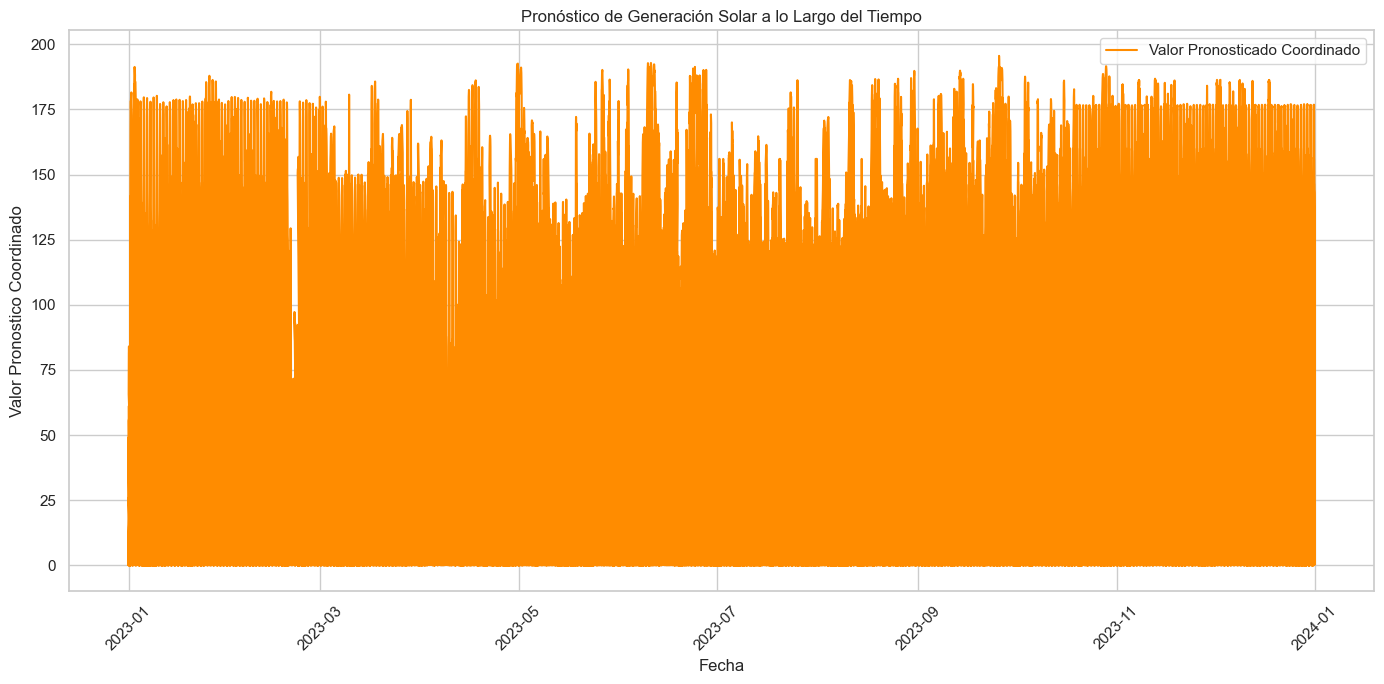

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\3098894562.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Coordinado', data=data, palette="coolwarm")


count    353184.000000
mean         26.800622
std          34.714975
min           0.000000
25%           2.940000
50%          12.390000
75%          36.500000
max         195.550000
Name: Coordinado, dtype: float64

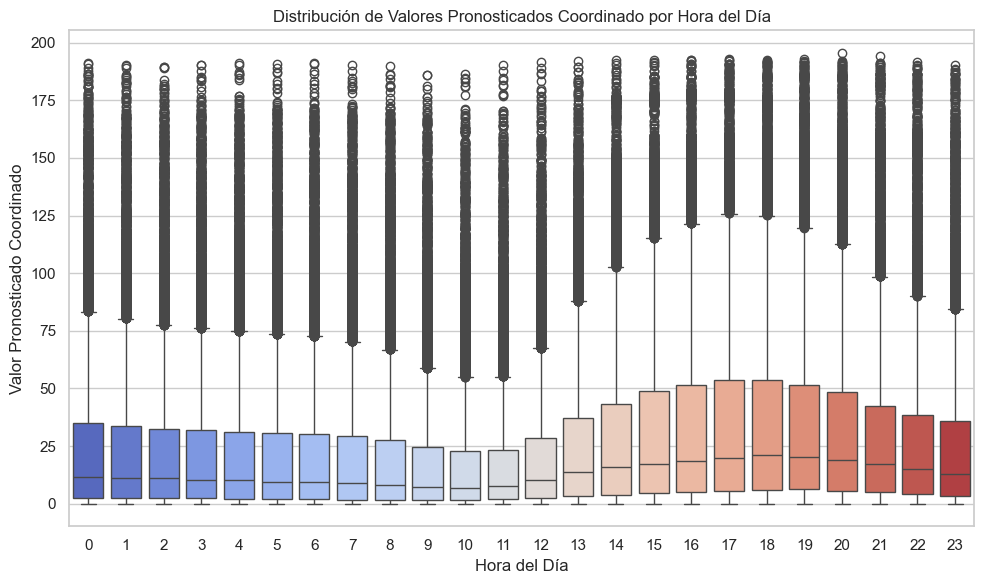

In [ ]:

# Configuración de visualización
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Coordinado'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Coordinado'], label='Valor Pronosticado Coordinado', color='darkorange')
plt.title('Pronóstico de Generación Solar a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Pronostico Coordinado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Coordinado', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronosticados Coordinado por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronosticado Coordinado')
plt.tight_layout()

descripcion


### Data set Pronostico Sistema Experto


In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Eolicos"
prefijo_archivo = "SistemaExpertoEolico"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados


Archivo encontrado: SistemaExpertoEolico - ABR23.xlsx en 2023/Datos Eolicos\Eolico-Abril-2023\Datos Eólicos Abril 2023
Archivo encontrado: SistemaExpertoEolico - AGO23.xlsx en 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023
Archivo encontrado: SistemaExpertoEolico - DIC23.xlsx en 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023
Archivo encontrado: SistemaExpertoEolico - ENE23.xlsx en 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023
Archivo encontrado: SistemaExpertoEolico - FEB23.xlsx en 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023
Archivo encontrado: SistemaExpertoEolico - JUL23.xlsx en 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023
Archivo encontrado: SistemaExpertoEolico - JUN23.xlsx en 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023
Archivo encontrado: SistemaExpertoEolico - MAR23.xlsx en 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023
Archivo encontrado: SistemaExperto

Leyendo archivo: 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023\SistemaExpertoEolico - AGO23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023\SistemaExpertoEolico - DIC23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023\SistemaExpertoEolico - ENE23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023\SistemaExpertoEolico - FEB23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023\SistemaExpertoEolico - JUL23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023\SistemaExpertoEolico - JUN23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023\SistemaExpertoEolico - MAR23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Mayo-2023\Datos Eólicos Mayo 2023\SistemaExpertoEolico - MAY23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Noviembre-2023\Datos eólicos noviembre 20

In [ ]:
data.rename(columns={'Valor':'SExperto'}, inplace=True)
SExperto = data

In [ ]:
SExperto

,Nombre,Fecha,SExperto
0,PE CANELA,2023-04-01 00:00:00,3.115
1,PE CANELA,2023-04-01 01:00:00,2.534
2,PE CANELA,2023-04-01 02:00:00,2.010
3,PE CANELA,2023-04-01 03:00:00,1.380
4,PE CANELA,2023-04-01 04:00:00,0.921
...,...,...,...
368146,PE CANELA II,2023-09-30 19:00:00,1.623
368147,PE CANELA II,2023-09-30 20:00:00,2.002
368148,PE CANELA II,2023-09-30 21:00:00,2.085
368149,PE CANELA II,2023-09-30 22:00:00,2.247


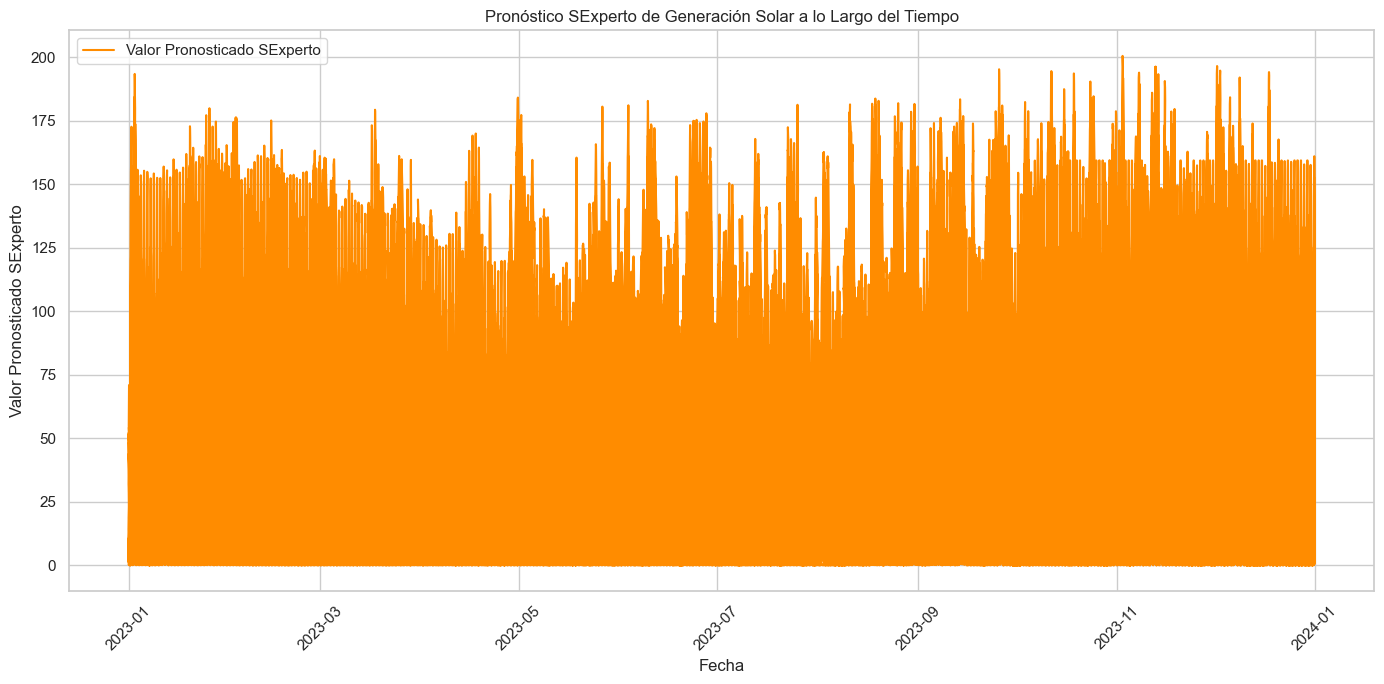

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\3273944543.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='SExperto', data=data, palette="coolwarm")


count    368151.000000
mean         26.797601
std          31.198616
min           0.000000
25%           4.836000
50%          14.949000
75%          37.282500
max         200.500000
Name: SExperto, dtype: float64

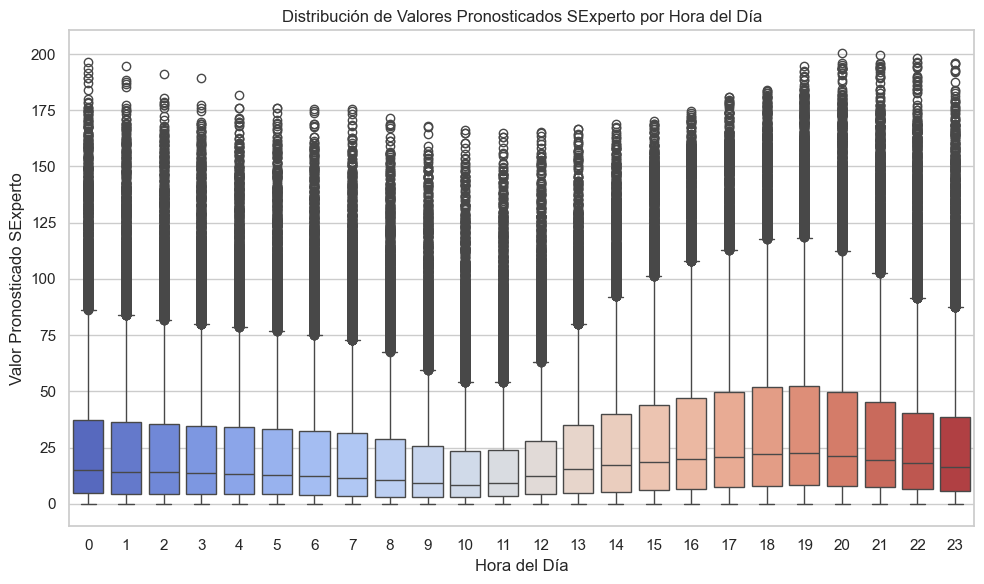

In [ ]:
# Configuración de visualización
#data = df7
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['SExperto'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['SExperto'], label='Valor Pronosticado SExperto', color='darkorange')
plt.title('Pronóstico SExperto de Generación Solar a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Pronosticado SExperto')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='SExperto', data=data, palette="coolwarm")
plt.title('Distribución de Valores Pronosticados SExperto por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronosticado SExperto')
plt.tight_layout()

descripcion


### Data Set Vertimiento

In [ ]:
def encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo):
    archivos_eolicos = []
    for raiz, dirs, archivos in os.walk(directorio_raiz):
        for archivo in archivos:
            if archivo.startswith(prefijo_archivo):
                ruta_completa = os.path.join(raiz, archivo)
                archivos_eolicos.append(ruta_completa)  # Agregar la ruta completa a la lista
                print(f"Archivo encontrado: {archivo} en {raiz}")
    return archivos_eolicos

def leer_y_combinar_archivos(rutas_archivos):
    dataframes = []
    for ruta in rutas_archivos:
        print(f"Leyendo archivo: {ruta}")
        df = pd.read_excel(ruta, engine='openpyxl')
        dataframes.append(df)
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
    else:
        merged_df = pd.DataFrame()  # Crear un DataFrame vacío si no hay archivos
    return merged_df

# Definir el directorio raíz y el prefijo de los archivos a buscar
directorio_raiz = "2023/Datos Eolicos"
prefijo_archivo = "Vertimiento"

# Encontrar los archivos eólicos y leerlos en DataFrames de Pandas
rutas_archivos_encontrados = encontrar_archivos_eolicos(directorio_raiz, prefijo_archivo)

# Combinar los DataFrames en uno solo
data = leer_y_combinar_archivos(rutas_archivos_encontrados)

# 'data' es ahora el DataFrame que contiene todos los datos combinados de los archivos eólicos encontrados

Archivo encontrado: Vertimiento - ABR23.xlsx en 2023/Datos Eolicos\Eolico-Abril-2023\Datos Eólicos Abril 2023
Archivo encontrado: Vertimiento - AGO23.xlsx en 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023
Archivo encontrado: Vertimiento - DIC23.xlsx en 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023
Archivo encontrado: Vertimiento - ENE23.xlsx en 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023
Archivo encontrado: Vertimiento - FEB23.xlsx en 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023
Archivo encontrado: Vertimiento - JUL23.xlsx en 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023
Archivo encontrado: Vertimiento - JUN23.xlsx en 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023
Archivo encontrado: Vertimiento - MAR23.xlsx en 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023
Archivo encontrado: Vertimiento - MAY23.xlsx en 2023/Datos Eolicos\Eolico-Mayo-2023\Datos Eólicos Mayo 202

Leyendo archivo: 2023/Datos Eolicos\Eolico-Agosto-2023\Datos Eólicos Agosto 2023\Vertimiento - AGO23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Diciembre-2023\Datos eólicos diciembre 2023\Vertimiento - DIC23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Enero-2023\Datos Eólicos Enero 2023\Vertimiento - ENE23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Febrero-2023\Datos Eólicos Febrero 2023\Vertimiento - FEB23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Julio-2023\Datos Eólicos Julio 2023\Vertimiento - JUL23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Junio-2023\Datos Eólicos Junio 2023\Vertimiento - JUN23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Marzo-2023\Datos Eólicos Marzo 2023\Vertimiento - MAR23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Mayo-2023\Datos Eólicos Mayo 2023\Vertimiento - MAY23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-Noviembre-2023\Datos eólicos noviembre 2023\Vertimiento - NOV23.xlsx
Leyendo archivo: 2023/Datos Eolicos\Eolico-O

In [ ]:
data.describe(include='all').round(1)

,Fecha,Nombre,Valor
count,317976,317976,317544.0
unique,NaN,43,58908.0
top,NaN,PE AURORA,0.0
freq,NaN,8760,246590.0
mean,2023-07-17 07:27:50.661936640,NaN,NaN
min,2023-01-01 00:00:00,NaN,NaN
25%,2023-04-22 10:00:00,NaN,NaN
50%,2023-07-26 10:00:00,NaN,NaN
75%,2023-10-13 20:00:00,NaN,NaN
max,2023-12-31 23:00:00,NaN,NaN


In [ ]:
data = data[data['Valor'] != '-']

In [ ]:
data['Valor'] = data['Valor'].astype(float)
data.dtypes

Fecha     datetime64[ns]
Nombre            object
Valor            float64
dtype: object

In [ ]:
data.rename(columns={'Valor':'Vertimiento'}, inplace=True)
Vertimiento= data
Vertimiento.describe(include='all').round(1)

,Fecha,Nombre,Vertimiento
count,317518,317518,317086.0
unique,NaN,43,NaN
top,NaN,PE LA ESTRELLA,NaN
freq,NaN,8760,NaN
mean,2023-07-17 03:20:05.234348544,NaN,2.0
min,2023-01-01 00:00:00,NaN,0.0
25%,2023-04-22 06:00:00,NaN,0.0
50%,2023-07-26 04:00:00,NaN,0.0
75%,2023-10-13 12:00:00,NaN,0.0
max,2023-12-31 23:00:00,NaN,169.4


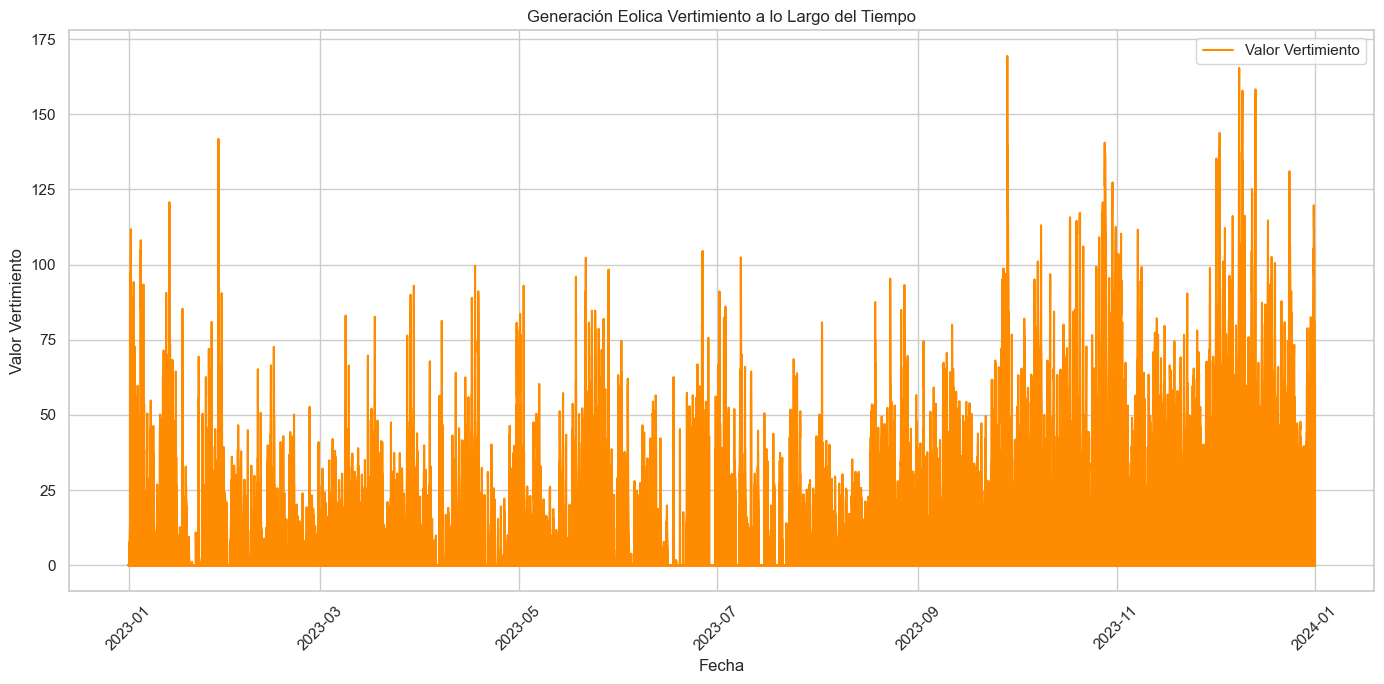

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_7448\10357648.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.boxplot(x='Hora', y='Vertimiento', data=data, palette="coolwarm")


count    317086.000000
mean          2.035195
std           7.526407
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         169.398500
Name: Vertimiento, dtype: float64

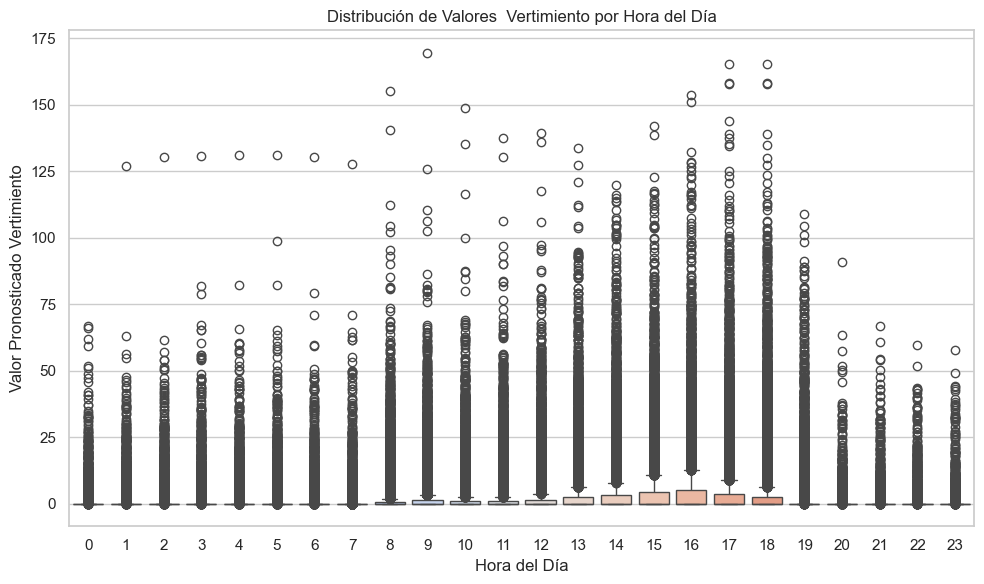

In [ ]:
# Configuración de visualización
#data = df7
sn.set(style="whitegrid")

# Análisis Descriptivo
descripcion = data['Vertimiento'].describe()

# Preparación para análisis temporal y por hora del día
data['Fecha'] = pd.to_datetime(data['Fecha'])  # Asegurar que 'Fecha' es datetime
data['Hora'] = data['Fecha'].dt.hour  # Extraer hora del día

# Análisis Temporal: Visualización de los valores pronosticados a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data['Fecha'], data['Vertimiento'], label='Valor Vertimiento', color='darkorange')
plt.title('Generación Eolica Vertimiento a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor Vertimiento')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Análisis por Hora del Día
plt.figure(figsize=(10, 6))
sn.boxplot(x='Hora', y='Vertimiento', data=data, palette="coolwarm")
plt.title('Distribución de Valores  Vertimiento por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Valor Pronosticado Vertimiento')
plt.tight_layout()

descripcion


### Union dataframes

In [ ]:
real
externo
coordinado
SExperto
Vertimiento

,Fecha,Nombre,Vertimiento,Hora
0,2023-04-01 00:00:00,PE AURORA,0.0,0
1,2023-04-01 01:00:00,PE AURORA,0.0,1
2,2023-04-01 02:00:00,PE AURORA,0.0,2
3,2023-04-01 03:00:00,PE AURORA,0.0,3
4,2023-04-01 04:00:00,PE AURORA,0.0,4
...,...,...,...,...
317971,2023-09-30 19:00:00,PE VALLE DE LOS VIENTOS,0.0,19
317972,2023-09-30 20:00:00,PE VALLE DE LOS VIENTOS,0.0,20
317973,2023-09-30 21:00:00,PE VALLE DE LOS VIENTOS,0.0,21
317974,2023-09-30 22:00:00,PE VALLE DE LOS VIENTOS,0.0,22


In [ ]:
df_cruzado = pd.merge(real, externo,  on=['Nombre', 'Fecha'], how='outer')
df_cruzado = pd.merge(df_cruzado, coordinado,  on=['Nombre', 'Fecha'], how='outer')
df_cruzado.drop(['Hora'],axis=1, inplace=True)
df_cruzado = pd.merge(df_cruzado, SExperto,  on=['Nombre', 'Fecha'], how='outer')
df_cruzado.drop(['Hora'],axis=1, inplace=True)
df_cruzado = pd.merge(df_cruzado, Vertimiento,  on=['Nombre', 'Fecha'], how='outer')
#df_cruzado.drop(['Hora'],axis=1, inplace=True)

In [ ]:
df = df_cruzado
Pronosticos = df_cruzado
#df['generacion_potencial'] = df['Real'] + df['Vertimiento'].fillna(0)
df['Tecnologia'] = 'Eolico'
df_eolico = df
df_eolico


,Real,Nombre,Fecha,Externo,Coordinado,SExperto,Vertimiento,Hora,Tecnologia
0,NaN,PE ALENA,2023-01-01 00:00:00,14.7,6.54,10.713,NaN,NaN,Eolico
1,37.07,PE ALENA,2023-01-01 01:00:00,10.4,3.86,7.258,NaN,NaN,Eolico
2,27.62,PE ALENA,2023-01-01 02:00:00,4.7,1.45,3.162,NaN,NaN,Eolico
3,15.90,PE ALENA,2023-01-01 03:00:00,2.5,1.04,1.798,NaN,NaN,Eolico
4,11.11,PE ALENA,2023-01-01 04:00:00,2.0,1.40,1.713,NaN,NaN,Eolico
...,...,...,...,...,...,...,...,...,...
383369,58.66,PE VALLE DE LOS VIENTOS,2023-12-31 20:00:00,64.7,71.24,65.324,0.0,20.0,Eolico
383370,86.35,PE VALLE DE LOS VIENTOS,2023-12-31 21:00:00,47.2,45.87,47.056,0.0,21.0,Eolico
383371,46.57,PE VALLE DE LOS VIENTOS,2023-12-31 22:00:00,27.4,20.42,26.695,0.0,22.0,Eolico
383372,16.55,PE VALLE DE LOS VIENTOS,2023-12-31 23:00:00,11.3,5.26,10.643,0.0,23.0,Eolico


In [ ]:
ruta_archivo_excel = 'df_eolico.xlsx'

# Usar el método to_excel para exportar el DataFrame a Excel, especificando el engine como 'openpyxl'
df.to_excel(ruta_archivo_excel, engine='openpyxl', index=False)

print(f'El DataFrame ha sido exportado a {ruta_archivo_excel}')

## Centrales

In [ ]:
df_unido = pd.merge(df_solar,df_eolico,  how='outer')
df_unido

,Real,Nombre,Fecha,Externo,Coordinado,SExperto,Vertimiento,Tecnologia
0,0.0,PE ALENA,2023-01-01 17:00:00,5.5,6.95,6.199,NaN,Eolico
1,0.0,PE ALENA,2023-01-01 18:00:00,3.9,13.36,8.420,NaN,Eolico
2,0.0,PE ALENA,2023-01-01 19:00:00,8.9,11.54,10.169,NaN,Eolico
3,0.0,PE ALENA,2023-01-01 20:00:00,20.0,14.89,17.533,NaN,Eolico
4,0.0,PE ALENA,2023-01-05 11:00:00,3.3,0.00,1.726,NaN,Eolico
...,...,...,...,...,...,...,...,...
893311,NaN,PFV TENO SOLAR,2023-07-01 00:00:00,NaN,0.00,NaN,NaN,Solar
893312,NaN,PFV URIBE SOLAR,2023-01-01 00:00:00,0.0,0.00,0.000,0.0,Solar
893313,NaN,PFV USYA,2023-01-01 00:00:00,0.0,0.00,0.000,0.0,Solar
893314,NaN,PFV VALLE DEL SOL,2023-10-01 00:00:00,0.0,NaN,0.000,0.0,Solar


In [ ]:
df_unido['Nombre'].unique()
#len(df_unido['Nombre'].unique())

array(['PE ALENA', 'PE AURORA', 'PE CABO LEONES', 'PE CABO LEONES II',
       'PE CABO LEONES III', 'PE CALAMA', 'PE CAMPO LINDO', 'PE CANELA',
       'PE CANELA II', 'PE CERRO TIGRE', 'PE CUEL', 'PE EL ARRAYAN',
       'PE EL MAITEN', 'PE LA ESPERANZA', 'PE LA ESTRELLA', 'PE LA FLOR',
       'PE LEBU', 'PE LLANOS DEL VIENTO', 'PE LOMAS DE DUQUECO',
       'PE LOS BUENOS AIRES', 'PE LOS CURUROS', 'PE LOS OLMOS',
       'PE MALLECO NORTE', 'PE MALLECO SUR', 'PE MESAMAVIDA',
       'PE MONTE REDONDO', 'PE NEGRETE', 'PE PUELCHE SUR',
       'PE PUNTA COLORADA', 'PE PUNTA PALMERAS', 'PE PUNTA SIERRA',
       'PE RENAICO I', 'PE SAN GABRIEL', 'PE SAN JUAN', 'PE SAN PEDRO',
       'PE SAN PEDRO II', 'PE SARCO', 'PE SIERRA GORDA ESTE',
       'PE TALINAY ORIENTE', 'PE TALINAY PONIENTE', 'PE TALTAL',
       'PE TCHAMMA', 'PE TOLPAN SUR', 'PE TOTORAL', 'PE UCUQUER II',
       'PE VALLE DE LOS VIENTOS', 'PFV ALMEYDA', 'PFV ANDES SOLAR',
       'PFV ANDES SOLAR II', 'PFV ATACAMA SOLAR II', 'PFV A

In [ ]:
rutaC= 'reporte_centrales.xlsx'
dfc = pd.read_excel(rutaC, engine='openpyxl')

In [ ]:
dfc['Tipo Central'].unique()
dfc.columns

Index(['ID', 'Nombre', 'Nombre Centro Control', 'Nombre Propietario',
       'Nombre Coordinado', 'Comuna', 'Tipo Central', 'Nemotecnico',
       'Descripcion', 'Estado (operativa/en pruebas/en construcción)',
       '11.1.1 Cantidad unidades generadoras',
       '11.1.2 Puntos de conexión al SI a través de los cuales inyecta energía.',
       '11.1.4 Potencia máxima bruta, para cada tipo de combustible que pueda operar',
       '11.1.5 Consumos propios como % de la potencia máxima bruta',
       '11.1.6 Capacidad máxima, potencia neta efectiva',
       '11.1.7 Potencia mínima técnica, para cada combustible que pueda operar',
       '11.1.11 Fecha de entrada en operación', 'Distribuidora',
       'Diagrama PQ equivalente de la central',
       '10.1.35 Tipo de conversión de energía', '10.1.35 Convencional / ERNC',
       '11.1.35 Combustible (solo para termoeléctricas)',
       '10.1.35 Medio de generación según DS 125-2019 y DS 88-2020',
       '11.1.38 Tipo de tecnología de la centra

In [ ]:
# Filtrado y selección de columnas en un solo paso
dfcc = dfc[dfc['Nombre'].isin(df_unido['Nombre'].unique())][
    ['Nombre', '11.1.38 Región', '11.1.8 Provincia', '11.1.8 Comuna', 
    '11.1.4 Potencia máxima bruta, para cada tipo de combustible que pueda operar', 'Nombre Propietario']
].copy()

# Renombrado de columnas
dfcc.rename(columns={
    '11.1.4 Potencia máxima bruta, para cada tipo de combustible que pueda operar': 'Potencia_max_bruta',
    '11.1.38 Región': 'Region',
    '11.1.8 Provincia': 'Provincia', 
    '11.1.8 Comuna': 'Comuna'
}, inplace=True)

# Transformaciones de datos en una secuencia encadenada
dfcc['Potencia_max_bruta'] = pd.to_numeric(dfcc['Potencia_max_bruta'], errors='coerce')
dfcc['Provincia'] = dfcc['Provincia'].str.upper().replace('DEL TAMARUGAL','TAMARUGAL')

# Visualización de datos y estructura
dfcc.describe(include='all').round(1)
dfcc.columns


Index(['Nombre', 'Region', 'Provincia', 'Comuna', 'Potencia_max_bruta',
       'Nombre Propietario'],
      dtype='object')

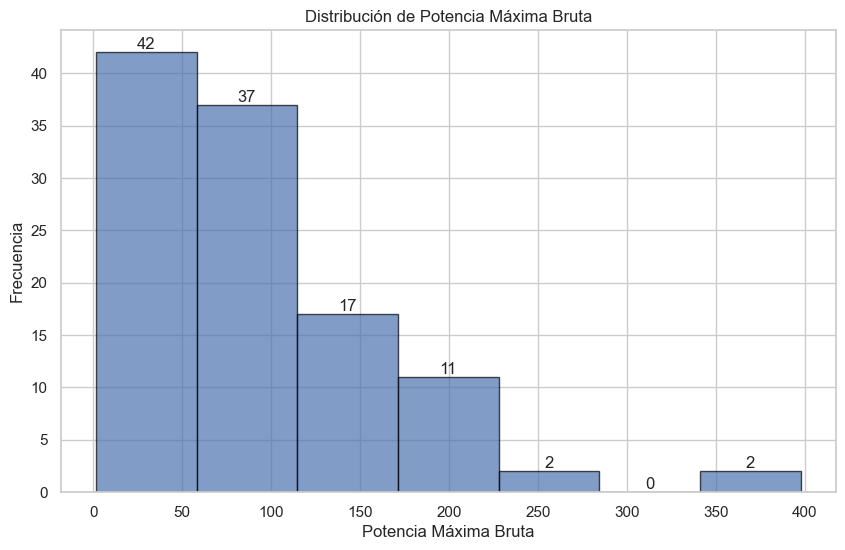

In [ ]:
# Supongamos que 'dfcc' es tu DataFrame y 'Potencia_max_bruta' es la columna de interés.
# Calculamos el número de bins usando la regla de Sturges.
N = 65  # Número total de filas en el DataFrame
bins = round(1 + np.log2(N))

# Establecer el tamaño de la figura aquí
plt.figure(figsize=(10, 6))

# Ahora generamos el histograma sin el argumento figsize.
n, bins, patches = plt.hist(dfcc['Potencia_max_bruta'], bins=bins, edgecolor='black', alpha=0.7)

# Configuramos las etiquetas y el título del gráfico.
plt.xlabel('Potencia Máxima Bruta')
plt.ylabel('Frecuencia')
plt.title('Distribución de Potencia Máxima Bruta')

# Añadir las frecuencias exactas sobre cada barra.
for i in range(len(n)):
    plt.text(bins[i]+((bins[i+1]-bins[i])/2), n[i], str(int(n[i])), ha='center', va='bottom')

# Mostramos el gráfico.
plt.show()

In [ ]:
df_f.isnull().sum()
df_f[df_f['Potencia_max_bruta'].isna()].describe(include='all').round(1)

,Real,Nombre,Fecha,Externo,Coordinado,SExperto,Vertimiento,Tecnologia,Region,Provincia,Comuna,Potencia_max_bruta,Nombre Propietario
count,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0
unique,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

df_f = pd.merge(df_unido, dfcc, on='Nombre', how='left')
df_f
df = df_f
df
df_solares = df[df['Tecnologia'] == 'Solar']
df_solares
df_eolicos = df[df['Tecnologia'] == 'Eolico']
df_eolicos

,Real,Nombre,Fecha,Externo,Coordinado,SExperto,Vertimiento,Tecnologia,Region,Provincia,Comuna,Potencia_max_bruta,Nombre Propietario
0,0.0,PE ALENA,2023-01-01 17:00:00,5.5,6.95,6.199,NaN,Eolico,BÍO BÍO,BÍO BÍO,Los Ángeles,86.20,AR ALENA SPA
1,0.0,PE ALENA,2023-01-01 18:00:00,3.9,13.36,8.420,NaN,Eolico,BÍO BÍO,BÍO BÍO,Los Ángeles,86.20,AR ALENA SPA
2,0.0,PE ALENA,2023-01-01 19:00:00,8.9,11.54,10.169,NaN,Eolico,BÍO BÍO,BÍO BÍO,Los Ángeles,86.20,AR ALENA SPA
3,0.0,PE ALENA,2023-01-01 20:00:00,20.0,14.89,17.533,NaN,Eolico,BÍO BÍO,BÍO BÍO,Los Ángeles,86.20,AR ALENA SPA
4,0.0,PE ALENA,2023-01-05 11:00:00,3.3,0.00,1.726,NaN,Eolico,BÍO BÍO,BÍO BÍO,Los Ángeles,86.20,AR ALENA SPA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893249,NaN,PE TCHAMMA,2023-01-01 00:00:00,1.7,1.75,1.726,0.0,Eolico,ANTOFAGASTA,EL LOA,Calama,157.50,AR TCHAMMA SPA
893250,NaN,PE TOLPAN SUR,2023-01-01 00:00:00,7.2,5.90,6.561,0.0,Eolico,ARAUCANÍA,MALLECO,Renaico,83.53,ACCIONA ENERGÍA CHILE HOLDINGS S.A.
893251,NaN,PE TOTORAL,2023-01-01 00:00:00,5.2,1.86,3.559,0.0,Eolico,COQUIMBO,CHOAPA,Canela,46.00,NORVIND S.A.
893252,NaN,PE UCUQUER II,2023-01-01 00:00:00,0.7,0.05,NaN,NaN,Eolico,LIBERTADOR GENERAL BERNARDO OHIGGINS,CARDENAL CARO,Litueche,10.75,ENERGÍAS UCUQUER DOS S.A.
